# Influencia de variables adicionales en la predicción de los niveles de glucosa en sangre.

Trabajo de Finalización de Máster en Inteligencia Artificial en la [Universidad Internacional de la Rioja (UNIR)](https://unir.net)

Realizado por [Xavi Coret Mayoral](https://xcoret.github.io/portfolio/)

El conjunto de datos utilizado ("Glucose_measurements_sample.csv") ha sido proporcionado por el director de este Trabajo de Fin de Máster, Ciro Rodríguez León.

## Instalación e importación de librerías necesarias

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Sequential
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout, BatchNormalization,CuDNNLSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Definición de constantes

In [2]:
# Etiquetas de los meses del año
MONTH_TAGS = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
# Etiquetas de los dias de la semana
WEEKDAY_TAGS = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
# Etiquetas de los momentos del dia
# DAYTIME_TAGS = ['Madrugada','Mañana','Mediodía','Tarde','Anochecer','Noche']
DAYTIME_TAGS = ['Madrugada','Mañana','Tarde','Noche']
# Etiquetas de tendencia
TREND_TAGS = ['Igual', 'Creciente', 'Decreciente']
# Etiquetas de diagnostico
HEALTHY_RANGE = [70,180] # https://doi.org/10.2337/dc22-S006
DIAGNOSTIC_TAGS = ['En rango','Por encima de rango','Por debajo de rango']
# Columnas del DataFrame
INITIAL_COLUMNS = ['Patient_ID',
                'Measurement_date',
                'Measurement_time',
                'Measurement'
]
FINAL_COLUMNS =['Patient_ID',
                'Measurement_date',
                'Measurement_time',                
                'Difference',
                'Trend',
                'Diagnostic',
                'Measurement_datetime',
                'Time_diff',
                'Unix_datetime',
                'Year',
                'Month',
                'Day',
                'Weekday',
                'Hour',
                'Minute',
                'Daytime',
                'Measurement'
]
TARGET_FEATURE = 'Normalized_Measurement'
# Carpeta de destino de los recursos generados
OUTPUT_FOLDER = os.path.join(os.getcwd(),'Output')
METRICS_FOLDER = os.path.join(OUTPUT_FOLDER,'Metrics')
CLARKE_FOLDER = os.path.join(OUTPUT_FOLDER,'Clarke')

DATA_FOLDER = os.path.join(os.getcwd(),'Data')
MODELS_FOLDER = os.path.join(DATA_FOLDER,'Models')
# Capeta de destino del dataframe de series temporales
TIME_SERIES_PATH = os.path.join(DATA_FOLDER,"Glucose_Time_Series.csv")
PREDICTIONS_PATH = os.path.join(DATA_FOLDER,"Predictions_test.csv")
SUMMARY_PATH = os.path.join(DATA_FOLDER,"Summary.csv")

# Crear en caso que no exista previamente
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
if not os.path.exists(MODELS_FOLDER):
    os.makedirs(MODELS_FOLDER)
if not os.path.exists(METRICS_FOLDER):
    os.makedirs(METRICS_FOLDER)
if not os.path.exists(CLARKE_FOLDER):
    os.makedirs(CLARKE_FOLDER)

# Color azul UNIR
UNIR_COLOR = '#0098CD'

# Longitud de las secuencias temporales
SEQUENCE_LENGTH = 12

# Rango de tiempo permitido entre los registros de una misma secuencia
TIME_DIFF_RANGE = [14,15,16]

# Definir el modo de representación de los valores en Pandas
pd.set_option('display.float_format', '{:.5f}'.format)

# Tamaño del conjunto de training sobre el conjunto de datos completo
TRAIN_RATIO = 0.80
# Tamaño del conjunto de test sobre el conjunto de datos completo
TEST_RATIO = 0.20
# Tamaño del conjunto de validacion sobre el conjunto test
VALIDATION_RATIO = 0.5
# Instanciar SCALER para normalizar los datos entre 0 y 1
SCALER = MinMaxScaler()

# Etiquetas de las zonas de la rejilla de error de Clarke
ZONE_LABELS = ['A', 'B', 'C', 'D', 'E']
# Descripciones de las zonas de la rejilla de error de Clarke
ZONE_DESCRIPTIONS = {
    'A': "dentro del 20% del sensor de referencia",
    'B': "fuera del 20% pero no conduciría a un tratamiento inapropiado",
    'C': "que indican un tratamiento innecesario",
    'D': "que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia",
    'E': "que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa"
}

# Epocas y tamaño de lote pare los entrenamientos de las redes
EPOCHS = 10
BATCH_SIZE = 128

pd.options.mode.chained_assignment = None  # default='warn'

## Definición de funciones

### Número de mediciones por paciente

In [3]:
def measurementsPerPatient(dataframe):
    """
    Esta función muestra información sobre el número de mediciones por paciente en un DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones de los pacientes.

    Descripción:
    - Calcula el número total de pacientes únicos en el DataFrame.
    - Imprime en pantalla el número de pacientes únicos.
    - Calcula la cantidad de mediciones por cada paciente.
    - Genera un gráfico de barras que muestra la cantidad de mediciones para cada paciente.

    Argumentos de gráfico:
    - El eje X representa los identificadores de los pacientes.
    - El eje Y muestra el número de mediciones para cada paciente.
    - Se utiliza una paleta de colores predeterminada (UNIR_COLOR) para las barras.

    Nota:
    - Asegúrate de que el DataFrame contenga una columna denominada 'Patient_ID', que identifica a cada paciente.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Patient_ID': [1, 2, 3, 2, 1, 4, 3, 5]})
    >> measurementsPerPatient(dataframe_ejemplo)
    """
    # Obtener los valores únicos de la columna 'Patient_ID' del DataFrame.
    unique_values = dataframe['Patient_ID'].unique()
    # Imprimir el número de pacientes únicos en el DataFrame.
    print('Número de pacientes: {}'.format(len(unique_values)))
    # Contar la cantidad de mediciones para cada paciente y almacenarla en 'examples_per_patient'.
    examples_per_patient = dataframe['Patient_ID'].value_counts()
    # Crear una figura de tamaño 20x6 para la visualización.
    plt.figure(figsize=(20, 6))
    # Crear un gráfico de barras con los pacientes en el eje x y el número de mediciones en el eje y.
    # Se utiliza el color 'UNIR_COLOR' para las barras, aunque este valor no está definido en el código proporcionado.
    plt.bar(examples_per_patient.index, examples_per_patient.values, color=UNIR_COLOR)
    # Añadir título y etiquetas a los ejes.
    plt.title('Número de mediciones por paciente')
    plt.xlabel('Paciente')
    plt.ylabel('Número de mediciones')
    # Habilitar la cuadrícula en el gráfico.
    plt.grid(True)
    # Rotar los nombres de los pacientes en el eje x para mejorar la legibilidad.
    plt.xticks(rotation=90)
    # Establecer los límites del eje x para evitar que las barras se recorten.
    plt.xlim(-0.6, len(examples_per_patient) - 0.6)
    # Mostrar el gráfico.
    plt.show()


### Número de mediciones por año

In [4]:
def measurementPerYear(dataframe):
    """
    Esta función muestra información sobre el número de mediciones por año en un DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones con sus respectivas fechas.

    Descripción:
    - Realiza una copia del DataFrame para no alterar los datos originales.
    - Convierte la columna 'Measurement_date' a formato de fecha y hora (datetime).
    - Imprime en pantalla la fecha del primer registro y la fecha del último registro en el DataFrame.
    - Calcula el número de mediciones para cada año presente en el DataFrame.
    - Genera un gráfico de barras que muestra la cantidad de mediciones para cada año.

    Argumentos de gráfico:
    - El eje X representa los años en los que se realizaron mediciones.
    - El eje Y muestra el número de mediciones para cada año.
    - Se utiliza una paleta de colores predeterminada (UNIR_COLOR) para las barras.
    - Se agregan etiquetas en la parte superior de cada barra que indican el número de mediciones para ese año.

    Nota:
    - Asegúrate de que el DataFrame contenga una columna denominada 'Measurement_date', que indique la fecha de cada medición.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Measurement_date': ['2022-01-01', '2022-02-15', '2023-03-20', '2023-04-10', '2023-05-05']})
    >> measurementPerYear(dataframe_ejemplo)
    """
    # Realizar una copia del DataFrame para no alterar los datos originales.
    temp_df = dataframe.copy()
    # Convertir la columna 'Measurement_date' a formato de fecha y hora (datetime).
    temp_df['Measurement_date'] = pd.to_datetime(temp_df['Measurement_date'])
    # Imprimir en pantalla la fecha del primer registro y la fecha del último registro en el DataFrame.
    print('Fecha del primer registro: {}\nFecha del último registro {}'.format(
        str(temp_df['Measurement_date'].min()).split(' ')[0],
        str(temp_df['Measurement_date'].max()).split(' ')[0]))
    # Calcular el número de mediciones para cada año presente en el DataFrame.
    year_counts = temp_df['Measurement_date'].dt.year.value_counts()
    # Generar un gráfico de barras que muestra la cantidad de mediciones para cada año.
    plt.figure(figsize=(8, 6))
    plt.bar(year_counts.index, year_counts.values, color=UNIR_COLOR)
    plt.xlabel('Año')
    plt.ylabel('Número de mediciones')
    plt.grid(True)
    plt.title('Número de mediciones por año')
    # Agregar etiquetas en la parte superior de cada barra que indican el número de mediciones para ese año.
    for i, value in enumerate(year_counts.values):
        plt.text(year_counts.index[i], value, str(value), ha='center', va='bottom')
    # Mostrar el gráfico.
    plt.show()

### Número de mediciones por mes

In [5]:
def monthlyMeasurement(dataframe):
    """
    Esta función muestra información sobre el número de mediciones por mes en un DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones con sus respectivas fechas.

    Descripción:
    - Realiza una copia del DataFrame para no alterar los datos originales.
    - Convierte la columna 'Measurement_date' a formato de fecha y hora (datetime).
    - Calcula el número de mediciones realizadas para cada mes presente en el DataFrame.
    - Genera un gráfico de barras que muestra la cantidad de mediciones para cada mes.

    Argumentos de gráfico:
    - El eje X representa los meses del año (números del 1 al 12).
    - El eje Y muestra el número de mediciones para cada mes.
    - Se utiliza una paleta de colores predeterminada (UNIR_COLOR) para las barras.
    - Se agregan etiquetas en la parte superior de cada barra que indican el número de mediciones para ese mes.
    - Los nombres de los meses se muestran en el eje X con etiquetas verticales.

    Constantes utilizadas:
    - MONTH_TAGS: Una lista de nombres de los meses en español para mostrar en el gráfico.

    Nota:
    - Asegúrate de que el DataFrame contenga una columna denominada 'Measurement_date', que indique la fecha de cada medición.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Measurement_date': ['2022-01-01', '2022-01-15', '2022-02-20', '2022-02-10', '2022-03-05']})
    >> monthlyMeasurement(dataframe_ejemplo)
    """
    # Realizar una copia del DataFrame para no alterar los datos originales.
    temp_df = dataframe.copy()
    # Convertir la columna 'Measurement_date' a formato de fecha y hora (datetime).
    temp_df['Measurement_date'] = pd.to_datetime(temp_df['Measurement_date'])
    # Calcular el número de mediciones para cada mes presente en el DataFrame.
    month_counts = temp_df['Measurement_date'].dt.month.value_counts()
    # Generar un gráfico de barras que muestra la cantidad de mediciones para cada mes.
    plt.figure(figsize=(8, 6))
    plt.bar(month_counts.index, month_counts.values, color=UNIR_COLOR)
    plt.xlabel('Mes')
    plt.ylabel('Número de mediciones')
    plt.grid(True)
    plt.title('Número de mediciones por mes')
    # Establecer etiquetas para los meses en el eje x, basadas en la variable MONTH_TAGS.
    plt.xticks(range(1, 13), [MONTH_TAGS[x-1] for x in range(1, 13)], rotation='vertical')
    # Agregar etiquetas en la parte superior de cada barra que indican el número de mediciones para ese mes.
    for i, value in enumerate(month_counts.values):
        plt.text(month_counts.index[i], value, str(value), ha='center', va='bottom')
    # Mostrar el gráfico.
    plt.show()

### Número de mediciones por mes y año

In [6]:
def monthlyMeasurementPerYear(dataframe):
    """
    Esta función muestra información sobre el número de mediciones por mes y año en un DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones con sus respectivas fechas.

    Descripción:
    - Crea un gráfico de líneas para representar la cantidad de mediciones por mes y año en el DataFrame.
    - Realiza una copia del DataFrame para no alterar los datos originales.
    - Convierte la columna 'Measurement_date' a formato de fecha y hora (datetime).
    - Obtiene una lista de años únicos presentes en el DataFrame y los ordena de forma ascendente.
    - Para cada año, filtra los datos correspondientes y calcula el número de mediciones realizadas en cada mes.
    - Representa los datos en el gráfico utilizando círculos (marcadores) para cada punto de datos por mes y año.

    Argumentos de gráfico:
    - El eje X representa los meses del año (números del 1 al 12).
    - El eje Y muestra el número de mediciones para cada mes.
    - Cada año se representa con una línea en el gráfico, y los puntos de datos por mes se muestran con círculos (marcadores).
    - Los nombres de los meses se muestran en el eje X con etiquetas verticales.
    - Se muestra una leyenda que identifica cada línea en el gráfico con el año correspondiente.

    Constantes utilizadas:
    - MONTH_TAGS: Una lista de nombres de los meses en español para mostrar en el gráfico.

    Nota:
    - Asegúrate de que el DataFrame contenga una columna denominada 'Measurement_date', que indique la fecha de cada medición.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Measurement_date': ['2022-01-01', '2022-02-15', '2023-03-20', '2023-04-10', '2023-05-05']})
    >> monthlyMeasurementPerYear(dataframe_ejemplo)
    """    
    # Crear una figura de tamaño 12x6 para el gráfico.
    plt.figure(figsize=(12, 6))
    # Realizar una copia del DataFrame para no alterar los datos originales.
    temp_df = dataframe.copy()
    # Convertir la columna 'Measurement_date' a formato de fecha y hora (datetime).
    temp_df['Measurement_date'] = pd.to_datetime(temp_df['Measurement_date'])
    # Obtener los años únicos presentes en el DataFrame y ordenarlos en orden ascendente.
    years = temp_df['Measurement_date'].dt.year.unique()
    years_sorted = sorted(years)
    # Iterar sobre cada año para obtener el número de mediciones por mes y trazar una línea para cada año en el gráfico.
    for year in years_sorted:
        year_data = temp_df[temp_df['Measurement_date'].dt.year == year]
        month_counts = year_data['Measurement_date'].dt.month.value_counts().sort_index()
        plt.plot(month_counts.index, month_counts.values, marker='o', label=str(year))
    # Configurar etiquetas y título del gráfico.
    plt.xlabel('Mes')
    plt.ylabel('Número de mediciones')
    plt.title('Número de mediciones por mes y año')
    plt.grid(True)
    # Establecer etiquetas para los meses en el eje x, basadas en la variable MONTH_TAGS.
    plt.xticks(range(1, 13), [MONTH_TAGS[x-1] for x in range(1, 13)], rotation='vertical')
    # Mostrar la leyenda en la esquina superior izquierda para identificar cada línea de año.
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    # Mostrar el gráfico.
    plt.show()

### Número de mediciones por dia de la semana

In [7]:
def weekdayMeasurement(dataframe):
    """
    Esta función muestra la media del nivel de glucosa por día de la semana en un DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones con sus respectivos días de la semana.

    Descripción:
    - Calcula la media del nivel de glucosa para cada día de la semana (de 0 a 6) en el DataFrame.
    - El DataFrame debe contener una columna llamada 'Weekday' que represente el día de la semana (0 para lunes, 1 para martes, ..., 6 para domingo).
    - Crea un gráfico de líneas para representar la media del nivel de glucosa para cada día de la semana.

    Argumentos de gráfico:
    - El eje X representa los días de la semana en español ('Lunes', 'Martes', ..., 'Domingo').
    - El eje Y muestra la media del nivel de glucosa para cada día de la semana.
    - Cada media se representa con un punto en el gráfico, con el valor mostrado encima de cada punto.

    Constantes utilizadas:
    - WEEKDAY_TAGS: Una lista de nombres de los días de la semana en español para mostrar en el gráfico.

    Nota:
    - Asegúrate de que el DataFrame contenga una columna denominada 'Weekday', que indique el día de la semana para cada medición.
    - La función calcula la media del nivel de glucosa para cada día de la semana y muestra estos valores en el gráfico.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Weekday': [0, 1, 2, 0, 1, 3, 4], 'Measurement': [100, 120, 110, 90, 130, 95, 105]})
    >> weekdayMeasurement(dataframe_ejemplo)
    """
    # Crear una lista vacía 'weekday_means' para almacenar las medias del nivel de glucosa para cada día de la semana.
    weekday_means = []
    # Iterar sobre los días de la semana y calcular la media del nivel de glucosa para cada día.
    for weekday in range(len(WEEKDAY_TAGS)):
        sample = dataframe[dataframe['Weekday'] == weekday]
        weekday_means.append(round(sample['Measurement'].describe()['mean'], 2))
    # Generar un gráfico de líneas que muestra la media del nivel de glucosa para cada día de la semana.
    plt.figure(figsize=(8, 6))
    plt.plot(WEEKDAY_TAGS, weekday_means, color=UNIR_COLOR)
    plt.xlabel('Día de la semana')
    plt.ylabel('Media del nivel de glucosa')
    plt.title('Media del nivel de glucosa por día de la semana')
    # Agregar etiquetas en la parte superior de cada punto de datos que indican la media correspondiente.
    for i, mean in enumerate(weekday_means):
        plt.text(i, mean, str(mean), ha='center', va='bottom')
    # Mostrar el gráfico.
    plt.show()

### Número de mediciones por momento del dia

In [8]:
def daytimeMeasurement(dataframe):
    """
    Esta función muestra la media del nivel de glucosa por momento del día en un DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones con sus respectivos momentos del día.

    Descripción:
    - Calcula la media del nivel de glucosa para cada momento del día en el DataFrame.
    - El DataFrame debe contener una columna llamada 'Daytime' que represente el momento del día (0 para mañana, 1 para tarde y 2 para noche).
    - Crea un gráfico de líneas para representar la media del nivel de glucosa para cada momento del día.

    Argumentos de gráfico:
    - El eje X representa los momentos del día en español ('Mañana', 'Tarde', 'Noche').
    - El eje Y muestra la media del nivel de glucosa para cada momento del día.
    - Cada media se representa con un punto en el gráfico, con el valor mostrado encima de cada punto.

    Constantes utilizadas:
    - DAYTIME_TAGS: Una lista de nombres de los momentos del día en español para mostrar en el gráfico.

    Nota:
    - Asegúrate de que el DataFrame contenga una columna denominada 'Daytime', que indique el momento del día para cada medición.
    - La función calcula la media del nivel de glucosa para cada momento del día y muestra estos valores en el gráfico.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Daytime': [0, 1, 2, 0, 1, 2, 0], 'Measurement': [100, 120, 110, 90, 130, 95, 105]})
    >> daytimeMeasurement(dataframe_ejemplo)
    """
    # Crear una lista vacía 'daytime_means' para almacenar las medias del nivel de glucosa para cada momento del día.
    daytime_means = []
    # Iterar sobre los momentos del día y calcular la media del nivel de glucosa para cada momento.
    for daytime in range(len(DAYTIME_TAGS)):
        sample = dataframe[dataframe['Daytime'] == daytime]
        daytime_means.append(round(sample['Measurement'].describe()['mean'], 2))
    # Generar un gráfico de líneas que muestra la media del nivel de glucosa para cada momento del día.
    plt.figure(figsize=(8, 6))
    plt.plot(DAYTIME_TAGS, daytime_means, marker='o', color=UNIR_COLOR)
    plt.xlabel('Momento del día')
    plt.ylabel('Media del nivel de glucosa')
    plt.title('Media del nivel de glucosa por momento del día')
    # Establecer etiquetas para los momentos del día en el eje x, basadas en la variable DAYTIME_TAGS.
    plt.xticks(range(len(DAYTIME_TAGS)), DAYTIME_TAGS, rotation='vertical')
    # Agregar etiquetas en la parte superior de cada punto de datos que indican la media correspondiente.
    for i, mean in enumerate(daytime_means):
        plt.text(i, mean, str(mean), ha='center', va='bottom')
    # Mostrar el gráfico.
    plt.show()

### Crear matriz de correlación de Pearson

In [9]:
def plotCorrelation(dataframe, columns_order,name):
    """
    Esta función muestra la matriz de correlación de Pearson para el conjunto de datos dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos para el análisis de correlación.
    columns_order (list): Una lista que representa el orden deseado de las columnas en el DataFrame.
    name (str): El nombre del conjunto de datos para etiquetar el gráfico.

    Descripción:
    - Reordena el DataFrame según la lista de columnas proporcionada.
    - Elimina la columna 'Patient_ID' del DataFrame.
    - Convierte las columnas 'Measurement_date' y 'Measurement_time' a formatos de fecha y hora (datetime).
    - Calcula la matriz de correlación de Pearson para todas las columnas del DataFrame.
    - Crea una versión de la matriz de correlación con los valores de correlación de la columna 'Measurement' en lugar de las correlaciones entre las columnas.
    - Muestra la matriz de correlación como un mapa de calor con anotaciones de los valores en cada celda.

    Argumentos de gráfico:
    - El eje X y el eje Y del mapa de calor representan las diferentes columnas del DataFrame.
    - Los valores dentro del mapa de calor son los coeficientes de correlación de Pearson, redondeados a dos decimales.

    Constantes utilizadas:
    - OUTPUT_FOLDER: La ruta de la carpeta de salida donde se guardará la imagen del mapa de calor.

    Nota:
    - Asegúrate de que el DataFrame contenga las columnas adecuadas para el análisis de correlación.

    Ejemplo de uso:
    >> columns_orden = ['Measurement_date', 'Measurement_time', 'Measurement', 'Columna1', 'Columna2']
    >> dataset_ejemplo = pd.DataFrame(...)
    >> plotCorrelation(dataset_ejemplo, columns_orden, 'Mi_Conjunto_De_Datos')

    """
    # Reorganizar las columnas del DataFrame siguiendo el orden especificado en 'columns_order'.
    dataframe.reindex(columns=columns_order)
    # Eliminar la columna 'Patient_ID' del DataFrame.
    dataframe = dataframe.drop('Patient_ID', axis=1)
    # Convertir las columnas 'Measurement_date' y 'Measurement_time' a formato de fecha y hora (datetime).
    dataframe['Measurement_date'] = pd.to_datetime(dataframe['Measurement_date'])
    dataframe['Measurement_time'] = pd.to_datetime(dataframe['Measurement_time'])
    # Calcular la matriz de correlación de Pearson para todas las columnas numéricas en el DataFrame.
    correlation_matrix = dataframe.corr()
    # Calcular la correlación de Pearson entre la columna 'Measurement' y todas las demás columnas numéricas.
    measurement_correlation = dataframe.corr()['Measurement']
    # Crear una copia de la matriz de correlación y reemplazar la fila y columna correspondientes a 'Measurement' 
    # con la correlación específica de 'Measurement' con otras columnas.
    correlation_matrix_filled = correlation_matrix.copy()
    correlation_matrix_filled['Measurement'] = measurement_correlation
    correlation_matrix_filled.loc['Measurement'] = measurement_correlation
    # Generar un mapa de calor (heatmap) para visualizar la matriz de correlación.
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_filled, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Matriz de Correlación de Pearson del conjunto de datos {}".format(name))
    plt.tight_layout()
    # Guardar la imagen del mapa de calor en una carpeta de salida (OUTPUT_FOLDER) con un nombre específico.
    plt.savefig(os.path.join(OUTPUT_FOLDER, 'pearson_{}.png'.format(name)))
    # Mostrar el mapa de calor en la pantalla.
    plt.show()

### Crear gráficas del entrenamiento

In [10]:
def plotTraining(model_name,history): 
    """
    Muestra la pérdida (MSE) durante el entrenamiento y validación de un modelo a lo largo de las épocas.

    Parámetros:
    model_name (str): El nombre o identificador del modelo que se está evaluando.
    history (dict): Un diccionario que contiene los datos históricos de entrenamiento del modelo, incluyendo las pérdidas de entrenamiento y validación.

    Descripción:
    - Extrae los valores de pérdida de entrenamiento y validación del historial proporcionado.
    - Crea un gráfico para representar la pérdida durante el entrenamiento y validación a lo largo de las épocas.

    Argumentos de gráfico:
    - El eje X representa las épocas del entrenamiento del modelo.
    - El eje Y muestra el valor de la pérdida (MSE) para cada época.
    - Se utiliza una paleta de colores predeterminada para representar las líneas de pérdida de entrenamiento y validación.

    Constantes utilizadas:
    - UNIR_COLOR: El color predeterminado para representar las líneas de pérdida de entrenamiento.
    - OUTPUT_FOLDER: La ruta de la carpeta de salida donde se guardará la imagen del gráfico.

    Nota:
    - Asegúrate de proporcionar el diccionario 'history' que contenga las pérdidas de entrenamiento y validación del modelo.

    Ejemplo de uso:
    >> history_ejemplo = {'loss': [0.01, 0.005, 0.003, ...], 'val_loss': [0.015, 0.009, 0.007, ...]}
    >> plotTraining('Modelo 1', history_ejemplo)
    """
    # Obtener las listas de pérdida durante el entrenamiento y la validación desde el historial del modelo.
    train_loss = history['loss']
    val_loss = history['val_loss']
    # Crear una figura para el gráfico de pérdida.
    plt.figure(figsize=(8, 6))
    # Graficar las pérdidas durante el entrenamiento y la validación.
    plt.plot(train_loss, label='Entrenamiento', marker='o', color=UNIR_COLOR)
    plt.plot(val_loss, label='Validación', marker='o', color='#FF6732')
    # Configurar títulos, etiquetas de ejes y leyendas.
    plt.title('Pérdida (MSE) en Entrenamiento y Validación Loss\n{}'.format(model_name))
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.legend()
    # Encontrar el valor mínimo y máximo de pérdida durante el entrenamiento y la validación.
    min_train_loss = min(train_loss)
    max_train_loss = max(train_loss)
    min_val_loss = min(val_loss)
    max_val_loss = max(val_loss)
    # Definir un pequeño desplazamiento (pad) para colocar las etiquetas en la gráfica.
    pad = 0.00002
    # Agregar etiquetas en la gráfica que muestran el valor mínimo y máximo de pérdida en el entrenamiento y la validación.
    plt.text(train_loss.index(min_train_loss), min_train_loss+pad, '{:.7f} min E'.format(min_train_loss), ha='center', va='bottom', color=UNIR_COLOR)
    plt.text(train_loss.index(max_train_loss), max_train_loss+pad, '{:.7f} max E'.format(max_train_loss), ha='center', va='bottom', color=UNIR_COLOR)
    plt.text(val_loss.index(min_val_loss), min_val_loss-pad, '{:.7f} min V'.format(min_val_loss), ha='center', va='top', color='#FF6732')
    plt.text(val_loss.index(max_val_loss), max_val_loss-pad, '{:.7f} max V'.format(max_val_loss), ha='center', va='top', color='#FF6732')
    # Ajustar los límites del eje y para que el gráfico sea más legible.
    plt.ylim(min(min_train_loss, min_val_loss)-0.0001, max(max_train_loss, max_val_loss)+0.0001)
    # Ajustar el diseño de la figura para evitar superposiciones de elementos.
    plt.tight_layout()
    # Guardar el gráfico en una carpeta de salida (OUTPUT_FOLDER) con un nombre específico.
    plt.savefig(os.path.join(MODELS_FOLDER, '{}_Training.png'.format(model_name)))
    # Mostrar el gráfico en la pantalla.
    plt.show()

### Rejilla de error de Clarke (adaptada)

In [11]:
'''
DISCLAIMER:
La función 'clarke_error_grid' ha sido recopilada del GitHub de Trevor Tsue y adaptada para la representación del trabajo actual
# https://github.com/suetAndTie/ClarkeErrorGrid/blob/master/ClarkeErrorGrid.py

'''

def clarke_error_grid(ref_values, pred_values, model_name):
    """
    Crea el Gráfico de Error de Clarke para evaluar el rendimiento de un modelo de predicción de glucosa.

    Parámetros:
    ref_values (list): Una lista que contiene los valores de glucosa de referencia.
    pred_values (list): Una lista que contiene los valores de glucosa predichos por el modelo.
    model_name (str): El nombre o identificador del modelo que se está evaluando.

    Descripción:
    - Comprueba que las longitudes de las listas de referencia y predicción sean iguales.
    - Crea el Gráfico de Error de Clarke para visualizar la concordancia entre los valores de referencia y los valores predichos.
    - Calcula las estadísticas de las zonas de acuerdo con el Gráfico de Error de Clarke.

    Argumentos de gráfico:
    - El eje X representa los valores de glucosa de referencia.
    - El eje Y representa los valores de glucosa predichos por el modelo.
    - Los puntos de datos se representan como puntos con transparencia.
    - Las regiones del Gráfico de Error de Clarke se identifican con letras A, B, C, D, y E.

    Constantes utilizadas:
    - OUTPUT_FOLDER: La ruta de la carpeta de salida donde se guardará la imagen del Gráfico de Error de Clarke.

    Retorna:
    - Un objeto "plt" que contiene el gráfico del Gráfico de Error de Clarke.
    - Un diccionario "zones" con el conteo de puntos en cada zona (A, B, C, D, E).

    Ejemplo de uso:
    >> ref_values_ejemplo = [100, 110, 120, 130, 140]
    >> pred_values_ejemplo = [95, 105, 125, 130, 135]
    >> clarke_error_grid(ref_values_ejemplo, pred_values_ejemplo, 'Mi_Modelo')

    """
    # Comprobación de que las longitudes de los arrays de referencia y predicción son iguales.
    # Si son diferentes, se levanta una excepción con un mensaje de error.
    assert (len(ref_values) == len(pred_values)), "Número desigual de valores (referencia: {}) (predicción: {}).".format(len(ref_values), len(pred_values))
    # Limpiar el gráfico actual antes de crear uno nuevo.
    plt.clf()
    # Crear una figura para el gráfico de Error de Clarke.
    plt.figure(figsize=(8, 8))
    # Configurar el gráfico.
    # Se utiliza un scatter plot para representar las mediciones de referencia (ref_values) frente a las predicciones (pred_values).
    # Los datos se muestran con un círculo ('o') de color '#0098CD' y tamaño 8, con una transparencia (alpha) de 0.25.
    plt.scatter(ref_values, pred_values, marker='o', color='#0098CD', s=8, alpha=0.25)
    # Agregar títulos y etiquetas de los ejes.
    plt.title(model_name + " Gráfico de Error de Clarke")
    plt.xlabel("Concentración de Referencia (mg/dl)")
    plt.ylabel("Concentración de Predicción (mg/dl)")
    # Configurar los valores de los ejes x e y con intervalos de 50 desde 0 hasta 550.
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])
    # Establecer el color de fondo del gráfico en blanco.
    plt.gca().set_facecolor('white')
    # Establecer las longitudes de los ejes x e y y ajustar el aspecto del gráfico para que sea cuadrado.
    plt.gca().set_xlim([0, 550])
    plt.gca().set_ylim([0, 550])
    plt.gca().set_aspect((400)/(400))
    # Agregar líneas de referencia en el gráfico.
    # Estas líneas definen las distintas zonas A, B, C, D y E del gráfico de Error de Clarke.
    # Cada zona tiene un significado particular en términos de precisión y desviación de las mediciones.
    plt.plot([0, 550], [0, 550], ':', c='black')  # Línea de regresión teórica de 45 grados
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 550/1.2], [70, 550], '-', c='black')  # Reemplazar 320 con 400/1.2 porque 100*(400 - 400/1.2)/(400/1.2) =  20% de error
    plt.plot([70, 70], [84, 550], '-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 440], [180, 550], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')  # Reemplazar 175.3 con 56 porque 100*abs(56-70)/70) = 20% de error
    plt.plot([70, 550], [56, 440], '-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 550], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180], '-', c='black')
    plt.plot([240, 550], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')
    # Agregar títulos de zonas en el gráfico para indicar la interpretación de cada zona.
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)
    # Agregar una cuadrícula al gráfico.
    plt.grid(True)
    # Calcular las estadísticas de los datos y contar cuántos puntos caen en cada zona.
    zone = [0] * 5
    zones = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2 * ref_values[i] and pred_values[i] >= 0.8 * ref_values[i]):
            zone[0] += 1  # Zona A
            zones['A'] += 1
        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1  # Zona E
            zones['E'] += 1
        elif ((ref_values[i] >= 70 and ref_values[i] <= 440) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7 / 5) * ref_values[i] - 182)):
            zone[2] += 1  # Zona C
            zones['C'] += 1
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175 / 3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175 / 3 and ref_values[i] <= 70) and pred_values[i] >= (6 / 5) * ref_values[i]):
            zone[3] += 1  # Zona D
            zones['D'] += 1
        else:
            zone[1] += 1  # Zona B
            zones['B'] += 1
    # Guardar el gráfico en una carpeta de salida (OUTPUT_FOLDER) con un nombre específico.
    plt.savefig(os.path.join(CLARKE_FOLDER, '{}_Clarke.png'.format(model_name)))
    # Devolver el objeto de gráfico 'plt' y el diccionario 'zones' con las estadísticas de las zonas.
    return plt, zones



### Añadir variables extraidas

In [12]:
def addAdditionalVariables(dataframe):
    """
    Agrega variables adicionales inferidas al DataFrame dado, basadas en la información de fechas, horas y mediciones.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones.

    Descripción:
    - Combina las columnas de fecha y hora para crear una nueva columna "Measurement_datetime" con el formato datetime.
    - Convierte la columna "Measurement" a tipo numérico para realizar cálculos numéricos.
    - Ordena el DataFrame por fecha y hora dentro de cada paciente para asegurar una secuencia temporal adecuada.
    - Calcula la diferencia de medición entre registros consecutivos para cada paciente y agrega esta información en la columna "Difference".
    - Calcula la tendencia de la medición (1 para diferencia positiva, -1 para diferencia negativa, 0 para ninguna diferencia) y agrega esta información en la columna "Trend".
    - Define el diagnóstico según el nivel de glucosa (1 para Hiperglucemia (más de 130), -1 para Hipoglucemia (menos de 70), 0 para nivel de glucemia controlado) y agrega esta información en la columna "Diagnostic".
    - Extrae componentes de fecha (año, mes y día) y agrega esta información en las columnas "Year", "Month" y "Day", respectivamente.
    - Calcula el día de la semana según la fecha y agrega esta información en la columna "Weekday".
    - Extrae componentes de tiempo (hora y minuto) y agrega esta información en las columnas "Hour" y "Minute", respectivamente.
    - Etiqueta el momento del día según la hora y agrega esta información en la columna "Daytime".
    - Convierte la fecha y hora a formato Unix como identificador de tiempo para secuencias temporales y agrega esta información en la columna "Unix_datetime".
    - Calcula la diferencia de tiempo entre registros anteriores por paciente y agrega esta información en la columna "Time_diff".

    Constantes utilizadas:
    - HEALTHY_RANGE: Una lista que contiene los límites inferior y superior para definir el rango de glucosa saludable.
    - DAYTIME_TAGS: Una lista de etiquetas para etiquetar el momento del día (en formato horario).
    - FINAL_COLUMNS: Una lista que contiene los nombres de las columnas finales que se deben mantener en el DataFrame después de agregar las variables.

    Retorna:
    - Un nuevo DataFrame con las variables adicionales inferidas y las columnas especificadas en "FINAL_COLUMNS".

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Measurement_date': ['2023-07-24', '2023-07-25'], 'Measurement_time': ['08:00', '12:30'], 'Measurement': [100, 120]})
    >> addAdditionalVariables(dataframe_ejemplo)

    """
    # Concatenar la columna de fecha y hora para crear una nueva columna "Measurement_datetime"
    dataframe['Measurement_datetime'] = pd.to_datetime(dataframe['Measurement_date'] + ' ' + dataframe['Measurement_time'])
    # Informar sobre las variables inferidas de medición
    print('Añadiendo variables inferidas de la medición:\n\t"Difference", "Trend", "Diagnostic"')
    # Convertir la columna "Measurement" a tipo numérico, manejando errores de conversión
    dataframe["Measurement"] = pd.to_numeric(dataframe["Measurement"], errors="coerce")
    # Ordenar el DataFrame por fecha y hora dentro de cada paciente
    dataframe = dataframe.groupby("Patient_ID", group_keys=False).apply(lambda x: x.sort_values(["Measurement_datetime"]))
    # Calcular la diferencia de medición entre registros consecutivos para cada paciente
    dataframe["Difference"] = dataframe.groupby("Patient_ID", group_keys=False)["Measurement"].diff().fillna(0)
    dataframe['Difference'] = pd.to_numeric(dataframe['Difference']).astype(int)
    # Calcular la tendencia de la medición (1 para diferencia positiva, -1 para diferencia negativa, 0 para ninguna diferencia)
    dataframe['Trend'] = np.sign(dataframe['Difference']).astype(int)
    # Definir el diagnóstico según el nivel de glucosa (1 para Hiperglucemia (más de 130), -1 para Hipoglucemia (menos de 70), 0 para nivel de glucemia controlado)
    dataframe['Diagnostic'] = np.where((dataframe['Measurement'] > HEALTHY_RANGE[1]), 1,np.where((dataframe['Measurement'] < HEALTHY_RANGE[0]), -1, 0)).astype(int)
    # Informar sobre las variables inferidas de la fecha
    print('Añadiendo variables inferidas de la fecha:\n\t"Year", "Month", "Day", "Weekday"')
    # Extraer componentes de la fecha (año, mes, día y día de la semana)
    dataframe['Year'] = dataframe['Measurement_datetime'].dt.year
    dataframe['Month'] = dataframe['Measurement_datetime'].dt.month
    dataframe['Day'] = dataframe['Measurement_datetime'].dt.day
    dataframe['Weekday'] = dataframe['Measurement_datetime'].dt.weekday
    # Informar sobre las variables inferidas de la hora
    print('Añadiendo variables inferidas de la hora:\n\t"Hour", "Minute", "Daytime"')
    # Extraer componentes de tiempo (hora y minuto) y etiquetar el momento del día según rangos de horas
    dataframe['Hour'] = dataframe['Measurement_datetime'].dt.hour
    dataframe['Minute'] = dataframe['Measurement_datetime'].dt.minute
    dataframe['Daytime'] = pd.cut(dataframe['Hour'], bins=[-1, 6, 12, 19, 24], labels=np.arange(len(DAYTIME_TAGS))).astype(int)
    # Informar sobre el formato Unix de fecha y hora
    print('Añadiendo fecha y hora en formato Unix:\n\t"Unix_datetime"')
    # Convertir la fecha y hora a formato Unix como identificador de tiempo para secuencias temporales
    dataframe['Unix_datetime'] = dataframe['Measurement_datetime'].apply(lambda x: int(x.timestamp()))
    # Informar sobre la diferencia de tiempo entre registros anteriores por paciente
    print('Añadiendo diferencia de tiempo entre registros anteriores por paciente:\n\t"Time_diff"')
    # Calcular la diferencia de tiempo en minutos entre registros anteriores para cada paciente
    dataframe['Time_diff'] = dataframe.groupby('Patient_ID', group_keys=False)['Measurement_datetime'].diff().dt.total_seconds()//60
    dataframe['Time_diff'].fillna(15,inplace=True)
    # Los NA corresponden al primer registro de cada paciente, por eso lo establecemos en 15 y así no lo obviamos en posteriores procesamientos
    dataframe['Time_diff'] = dataframe['Time_diff'].astype(int)
    # Devolver el DataFrame con las columnas finales especificadas en 'FINAL_COLUMNS'
    return dataframe.reindex(columns=FINAL_COLUMNS)

### Crear series temporales

In [13]:
def createTemporalSeries(dataframe):
    """
    Crea secuencias temporales válidas a partir del DataFrame dado.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones y las variables adicionales.

    Descripción:
    - Imprime un mensaje indicando que se están creando las secuencias temporales.
    - Restablece los índices del DataFrame para facilitar el manejo.
    - Crea una lista "valid_indexes" para almacenar los índices de los registros que formarán parte de las secuencias temporales válidas.
    - Agrupa los registros del DataFrame por paciente.
    - Itera sobre cada grupo de pacientes y crea secuencias temporales válidas de longitud "SEQUENCE_LENGTH" basadas en la columna "Time_diff" y el rango "TIME_DIFF_RANGE".
    - Agrega los índices de los registros válidos a la lista "valid_indexes".

    Constantes utilizadas:
    - SEQUENCE_LENGTH: La longitud deseada para cada secuencia temporal válida.
    - TIME_DIFF_RANGE: El rango permitido de diferencia de tiempo entre registros consecutivos para formar parte de una secuencia.

    Retorna:
    - Un nuevo DataFrame que contiene solo los registros que forman parte de las secuencias temporales válidas.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Patient_ID': [1, 1, 1, 2, 2, 2], 'Measurement': [100, 120, 140, 90, 100, 110], 'Time_diff': [15, 20, 25, 10, 12, 17]})
    >> createTemporalSeries(dataframe_ejemplo)

    """
    # Informar que se está creando las series temporales
    print("Creando series temporales")
    # Restablecer el índice del DataFrame
    dataframe = dataframe.reset_index(drop=True)
    # Crear un diccionario vacío para almacenar los índices válidos
    valid_indexes = []
    # Agrupar los registros del conjunto de datos por paciente
    for patient_id, patient_data in dataframe.groupby("Patient_ID"):
        current_sequence = []  # Lista para almacenar los índices de la secuencia actual
        for index, row in patient_data.iterrows():
            if row['Time_diff'] in TIME_DIFF_RANGE:
                # Comprobar si la secuencia actual ha alcanzado la longitud deseada (SEQUENCE_LENGTH)
                if len(current_sequence) == SEQUENCE_LENGTH:
                    # Guardar la secuencia actual en la lista de índices válidos y reiniciar la secuencia
                    valid_indexes.extend(current_sequence)
                    current_sequence = []
                # Agregar el índice actual a la secuencia actual
                current_sequence.append(index)
            else:
                # Reiniciar la secuencia actual si el tiempo entre registros no cumple con las condiciones
                current_sequence = []
    # Devolver un nuevo DataFrame que incluye solo los registros con índices válidos
    return dataframe[dataframe.index.isin(valid_indexes)]

### Entreno de los modelos

In [14]:
def fitAndEvaluate(model, model_name, training_set, validation_set, test_set, epochs=10, batch_size=32):
    """
    Entrena un modelo dado y evalúa su rendimiento en un conjunto de datos de prueba.

    Parámetros:
        model (keras.Model): El modelo de Keras a entrenar y evaluar.
        model_name (str): Nombre del modelo.
        training_set (tuple): Tupla (X_train, y_train) que contiene las características de entrenamiento y las etiquetas correspondientes.
        validation_set (tuple): Tupla (X_validation, y_validation) que contiene las características de validación y las etiquetas correspondientes.
        test_set (tuple): Tupla (X_test, y_test) que contiene las características de prueba y las etiquetas correspondientes.
        epochs (int): Número de épocas de entrenamiento (predeterminado: 10).
        batch_size (int): Tamaño del lote durante el entrenamiento (predeterminado: 32).

    Descripción:
        - Desempaqueta los conjuntos de entrenamiento, validación y prueba.
        - Define las rutas de guardado para el modelo y el historial de entrenamiento.
        - Si el modelo aún no ha sido entrenado, inicia el proceso de entrenamiento:
            - Realiza el entrenamiento del modelo con los conjuntos de entrenamiento y validación.
            - Guarda el modelo en formato h5 y el historial de entrenamiento en un archivo pickle.
        - Si el modelo ya ha sido entrenado, carga el modelo y el historial de entrenamiento previo.
        - Grafica el progreso del entrenamiento utilizando la función plotTraining().
        - Evalúa el modelo en el conjunto de prueba y muestra la pérdida obtenida.
        - Realiza predicciones en el conjunto de prueba y revierte la transformación previa de escalado para obtener los valores reales.
        - Calcula y muestra diversas métricas de evaluación: Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Error Absoluto Medio (MAE) y Puntuación R^2.
        - Grafica la grilla de errores de Clarke y muestra el porcentaje de puntos en cada región de la grilla.
        - Devuelve una lista con los resultados de evaluación y análisis.

    Constantes utilizadas:
        - MODELS_FOLDER (str): Ruta de la carpeta donde se guardarán los modelos entrenados.
        - SCALER (objeto): Objeto de escalado utilizado para revertir la transformación previa de escalado en las predicciones.
        - ZONE_DESCRIPTIONS (dict): Diccionario que contiene descripciones de las regiones de la grilla de errores de Clarke.
        - SEQUENCE_LENGTH (int): La longitud deseada para cada secuencia temporal válida.
        - TIME_DIFF_RANGE (int): El rango permitido de diferencia de tiempo entre registros consecutivos para formar parte de una secuencia.

    Retorna:
        Una lista que contiene los siguientes elementos en orden:
        - Pérdida obtenida en el conjunto de prueba.
        - Error Cuadrático Medio (MSE).
        - Raíz del Error Cuadrático Medio (RMSE).
        - Error Absoluto Medio (MAE).
        - Puntuación R^2.
        - Predicciones del modelo en el conjunto de prueba (escaladas inversamente).
        - Lista con los valores de puntos en cada región de la grilla de errores de Clarke.
        - Tiempo total de entrenamiento en formato "horas:minutos:segundos".

    Ejemplo de uso:
        >> modelo = crear_modelo()  # Supongamos que ya tenemos una función crear_modelo() que devuelve un modelo de Keras.
        >> resultados = fitAndEvaluate(modelo, "ModeloEjemplo", train_set, validation_set, test_set, epochs=20, batch_size=64)
        >> print(resultados)
    """
    # Desempaquetar los conjuntos de entrenamiento, validación y prueba
    X_train, y_train = training_set
    X_validation, y_validation = validation_set
    X_test, y_test = test_set
    # Rutas de guardado para el modelo y el historial de entrenamiento
    model_path = os.path.join(MODELS_FOLDER, '{}.h5'.format(model_name))
    history_path = model_path.replace('.h5', '.pkl')
    if not os.path.exists(model_path):
        # Si el modelo aún no ha sido entrenado, inicia el proceso de entrenamiento
        print("\nEmpezando el entrenamiento del modelo {}".format(model_name))
        time_start = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size)        
        training_time = time.time() - time_start
        hours, remainder = divmod(training_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        training_seconds = "{:02d}:{:02d}:{:02d}".format(int(hours), int(minutes), int(seconds))
        print("\n - Duración del entrenamiento: {} \n".format(training_seconds))
        model.save(model_path)
        # Guardar el historial de entrenamiento en un archivo pickle
        with open(history_path, 'wb') as history_file:
            pickle.dump(history.history, history_file)
        print('Modelo "{}" guardado en:\n\t{}\nHistorial de entrenamiento guardado en:\n\t{}'.format(model_name, model_path, history_path))
        history_data = history.history        
    else:
        training_time = 0
        # Si el modelo ya existe, carga el modelo y el historial de entrenamiento previo
        print('\nEl modelo "{}" ya existe. \nCargando modelo e historial de entrenamiento.'.format(model_name))
        model = load_model(model_path)
        with open(history_path, 'rb') as history_file:
            history_data = pickle.load(history_file)         
    # Graficar el progreso del entrenamiento
    plotTraining(model_name, history_data)
    # Evaluar el modelo en el conjunto de prueba
    print('\n==== Resultados de evaluación del modelo ====\n')
    loss = model.evaluate(X_test, y_test)
    print('Pérdida (MSE) : {}'.format(loss))
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    # Invertir la transformación previa de escalado para obtener los valores reales
    y_pred = SCALER.inverse_transform(y_pred)
    y_test = SCALER.inverse_transform(y_test.reshape(-1, 1))
    # Calcular métricas de evaluación (MSE, RMSE, MAE, R^2)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('\n==== Resultados de test ====\n')
    print('Error Cuadrático Medio (MSE): {}'.format(mse))
    print('Raíz del Error Cuadrático Medio (RMSE): {}'.format(rmse))
    print('Error Absoluto Medio (MAE): {}'.format(mae))
    print('Puntuación R^2: {}'.format(r2))  
    # Graficar la grilla de errores de Clarke
    plot, zones = clarke_error_grid(y_test, y_pred, model_name)
    plot.show()
    # Calcular y mostrar el porcentaje de puntos en cada región de la grilla de errores de Clarke
    zone_values = []
    for zone_label in zones:
        if zone_label in ZONE_DESCRIPTIONS:        
            print("Región {}: {} puntos ({}%) {}".format(zone_label, zones[zone_label], round((zones[zone_label] / len(y_pred)) * 100,2), ZONE_DESCRIPTIONS[zone_label]))
            zone_values.append(zones[zone_label])
        else:        
            print("Región {}: {} puntos".format(zone_label, zones[zone_label]))
    print("Total casos: {}\n".format(len(y_pred)))
    # Devolver una lista con los resultados de evaluación y análisis
    return [loss, mse, rmse, mae, r2, y_pred, zone_values, training_time]


### Crear sets de entrenamiento, validación y prueba

In [15]:
def splitTrainValTest(dataframe, variables=['Measurement'], case=''):
    """
    Crea conjuntos de entrenamiento, validación y prueba a partir del DataFrame dado y las variables especificadas.

    Parámetros:
    dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones y las variables adicionales.
    variables (list, opcional): Una lista de strings que especifica las columnas a utilizar como variables para el modelo.
                                Predeterminado es ['Measurement'].
    case (str, opcional): Una cadena que identifica el caso o el escenario de la división de datos. Predeterminado es ''.

    Descripción:
    - Normaliza las variables especificadas utilizando el objeto "SCALER".
    - Crea un nuevo DataFrame solo con las variables normalizadas.
    - Construye secuencias de longitud "SEQUENCE_LENGTH" basadas en las variables normalizadas.
    - Divide las secuencias y las etiquetas en conjuntos de entrenamiento, validación y prueba utilizando las proporciones especificadas por las constantes TRAIN_RATIO, VALIDATION_RATIO y TEST_RATIO.
    - Ajusta las dimensiones de las matrices de entrada a la forma deseada para el modelo.

    Constantes utilizadas:
    - SEQUENCE_LENGTH: La longitud deseada para cada secuencia temporal válida.
    - TRAIN_RATIO: La proporción de datos a utilizar como conjunto de entrenamiento.
    - VALIDATION_RATIO: La proporción de datos a utilizar como conjunto de validación.
    - TEST_RATIO: La proporción de datos a utilizar como conjunto de prueba.

    Retorna:
    - Una lista que contiene los conjuntos de entrenamiento, validación y prueba en el siguiente formato:
      [training_set, validation_set, test_set]

    Cada conjunto contiene dos elementos:
    - training_set: Una lista con dos elementos [X_train, y_train], donde X_train es una matriz numpy que contiene las secuencias de entrenamiento,
      y_train es una matriz numpy que contiene las etiquetas de entrenamiento.
    - validation_set: Una lista con dos elementos [X_validation, y_validation], donde X_validation es una matriz numpy que contiene las secuencias de validación,
      y_validation es una matriz numpy que contiene las etiquetas de validación.
    - test_set: Una lista con dos elementos [X_test, y_test], donde X_test es una matriz numpy que contiene las secuencias de prueba,
      y_test es una matriz numpy que contiene las etiquetas de prueba.

    Ejemplo de uso:
    >> dataframe_ejemplo = pd.DataFrame({'Patient_ID': [1, 1, 1, 2, 2, 2], 'Measurement': [100, 120, 140, 90, 100, 110], 'Time_diff': [15, 20, 25, 10, 12, 17]})
    >> splitTrainValTest(dataframe_ejemplo, variables=['Measurement', 'Time_diff'], case='caso1')

    """
    print("Creando conjuntos de Entrenamiento, Validación y Prueba")
    # Si 'Measurement' no está en la lista de variables, se agrega.
    if 'Measurement' not in variables:
        variables.append('Measurement')

    # Normalizar las variables especificadas usando un SCALER 
    for variable in variables:
        dataframe.loc[:, 'Normalized_{}'.format(variable)] = SCALER.fit_transform(dataframe[variable].values.reshape(-1, 1))

    # Crear un nuevo DataFrame solo con las variables normalizadas.
    norm_names = list(map(lambda x: 'Normalized_{}'.format(x), variables))
    new_dataframe = dataframe[norm_names].copy().reset_index(drop=True)
    # print(new_dataframe.head())

    # Listas para almacenar las secuencias y las etiquetas.
    sequences = []
    labels = []
    tags = 0
    k = 0
    current_sequence = []

    # Iterar sobre las filas del nuevo DataFrame para construir las secuencias.
    for i, row in new_dataframe.iterrows():
        # print('{}[{}] : {}'.format(i,k,row['Normalized_Measurement']))
        
        # Agregar los valores normalizados de la fila actual a la secuencia actual.
        current_sequence.append(row.values.flatten().tolist())

        # Si se alcanza el tamaño de la secuencia deseada (SEQUENCE_LENGTH), o se llega al final del DataFrame,
        # guardar la secuencia actual y su etiqueta correspondiente en las listas 'sequences' y 'labels'.
        if (k % (SEQUENCE_LENGTH - 1) == 0 and k > 0) or k == len(new_dataframe):
            # print('---SAVING LABEL {} AT INDEX {}'.format(row['Normalized_Measurement'],i))
            
            k = 0
            sequences.append(current_sequence)
            labels.append(row['Normalized_Measurement'])
            current_sequence = []
        else:
            k += 1

    # Dividir las secuencias y etiquetas en conjuntos de entrenamiento, validación y prueba.
    X_train, temp_sequences, y_train, temp_labels = train_test_split(sequences, labels, test_size=TEST_RATIO, random_state=12081995)
    X_test, X_validation, y_test, y_validation = train_test_split(temp_sequences, temp_labels, test_size=VALIDATION_RATIO, random_state=12081995)

    # Convertir las listas a matrices numpy.
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_validation = np.array(X_validation)
    y_validation = np.array(y_validation)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Reajustar las dimensiones de las matrices de entrada a la forma deseada para el modelo.
    X_train = X_train.reshape(X_train.shape[0], SEQUENCE_LENGTH, len(variables))
    X_validation = X_validation.reshape(X_validation.shape[0], SEQUENCE_LENGTH, len(variables))
    X_test = X_test.reshape(X_test.shape[0], SEQUENCE_LENGTH, len(variables))

    # Imprimir información sobre los conjuntos de datos creados.
    total_size = len(sequences)
    print("Secuencias totales: {} ({} registros)".format(total_size, total_size * SEQUENCE_LENGTH))
    train_percent = int(((total_size * TRAIN_RATIO) / total_size) * 100)
    test_percent = int((((total_size * TEST_RATIO) / total_size) * 100) * 0.5)
    val_percent = test_percent
    
    print(" - Secuencias de entrenamiento: {} ({}%) - Etiquetas de entrenamiento: {}\nPrimera secuencia: \n{}\nEtiqueta: {}\n".format(len(X_train), train_percent, len(y_train), X_train[0].flatten(), y_train[0]))
    print(" - Secuencias de validación: {} ({}%) - Etiquetas de validación: {}\nPrimera secuencia: \n{}\nEtiqueta: {}\n".format(len(X_validation), val_percent, len(y_validation), X_validation[0].flatten(), y_validation[0])) 
    print(" - Secuencias de prueba: {} ({}%) - Etiquetas de prueba: {}\nPrimera secuencia: \n{}\nEtiqueta: {}\n".format(len(X_test), test_percent, len(y_test), X_test[0].flatten(), y_test[0]))
    
    return [X_train, y_train], [X_validation, y_validation], [X_test, y_test]

### Run cases

In [16]:
def runCases(dataframe, cases_summary):
    """
    Entrena y evalúa varios modelos LSTM con diferentes combinaciones de variables para cada caso.

    Parámetros:
        dataframe (DataFrame): El DataFrame que contiene los datos de las mediciones y las variables adicionales.
        cases_summary (dict): Un diccionario que contiene información sobre los casos y las variables asociadas.

    Descripción:
        - Se utiliza el optimizador Adam con una tasa de aprendizaje de 0.001 y una decadencia de 1e-6.
        - Loop a través de los casos (diferentes combinaciones de variables) en el diccionario "cases_summary".
        - Divide el conjunto de datos en conjuntos de entrenamiento, validación y prueba.
        - Crea y entrena tres modelos LSTM con diferentes arquitecturas.
        - Guarda los resultados de entrenamiento y evaluación de cada modelo en el diccionario "cases_summary".
        - Procesa los resultados y genera archivos CSV con un resumen de las métricas de rendimiento y las predicciones.

    Constantes utilizadas:
        - OUTPUT_FOLDER (str): Ruta de la carpeta donde se guardarán los gráficos y los archivos CSV generados.
        - EPOCHS (int): Número de épocas de entrenamiento para cada modelo LSTM.
        - BATCH_SIZE (int): Tamaño del lote durante el entrenamiento para cada modelo LSTM.
        - SEQUENCE_LENGTH (int): La longitud deseada para cada secuencia temporal válida.
        - SCALER (objeto): Objeto de escalado utilizado para revertir la transformación previa de escalado en las predicciones.

    Retorna:
        DataFrame: Un DataFrame que contiene un resumen de las métricas de rendimiento para cada modelo y caso.
    """
    optimizer = Adam(learning_rate=0.001, decay=1e-6)

    # Loop a través de los casos (diferentes combinaciones de variables)
    for case in cases_summary:
        variables = cases_summary[case][0]
        print('\n{}\n===== {} =====\n{}\nVariables usadas: {}'.format('='*95, case, '='*95, variables))
        
        # Dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba
        training_set, validation_set, test_set = splitTrainValTest(dataframe, variables, case)

        # Crear y entrenar el primer modelo
        model_name = '{}{}_M1'.format(case[0], case[-1])
        print('\n==== Primer modelo ({}) ====\n'.format(model_name))
        model1 = Sequential()
        model1.add(CuDNNLSTM(units=128, input_shape=(SEQUENCE_LENGTH, len(variables))))
        model1.add(Dense(units=32, activation="linear"))
        model1.add(Dense(1, activation='linear'))
        model1.summary()
        plot_model(model1, to_file=os.path.join(MODELS_FOLDER, '{}_diagram.png'.format(model_name)), show_shapes=True, show_layer_names=True)
        model1.compile(optimizer=optimizer, loss='mean_squared_error')
        cases_summary[case].append(fitAndEvaluate(model=model1, model_name=model_name.format(case), training_set=training_set, validation_set=validation_set, test_set=test_set, epochs=EPOCHS, batch_size=BATCH_SIZE))

        # Crear y entrenar el segundo modelo
        model_name = '{}{}_M2'.format(case[0], case[-1])
        print('\n==== Segundo modelo ({}) ====\n'.format(model_name))
        model2 = Sequential()
        model2.add(CuDNNLSTM(units=256, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(variables))))
        model2.add(Dropout(0.25))
        model2.add(CuDNNLSTM(128))
        model2.add(Dense(units=64, activation="linear"))
        model2.add(BatchNormalization())
        model2.add(Dropout(0.25))        
        model2.add(Dense(units=32, activation="linear"))
        model2.add(BatchNormalization())
        model2.add(Dropout(0.25))
        model2.add(Dense(1, activation='linear'))
        model2.summary()
        plot_model(model2, to_file=os.path.join(MODELS_FOLDER, '{}_diagram.png'.format(model_name)), show_shapes=True, show_layer_names=True)
        model2.compile(optimizer=optimizer, loss='mean_squared_error')
        cases_summary[case].append(fitAndEvaluate(model=model2, model_name=model_name.format(case), training_set=training_set, validation_set=validation_set, test_set=test_set, epochs=EPOCHS, batch_size=BATCH_SIZE))
        
        # Crear y entrenar el tercer modelo
        model_name = '{}{}_M3'.format(case[0], case[-1])            
        print('\n==== Tercer modelo ({}) ====\n'.format(model_name))  
        model3 = Sequential()
        model3.add(CuDNNLSTM(units=128, input_shape=(SEQUENCE_LENGTH, len(variables))))
        model3.add(Dropout(0.2))
        model3.add(Dense(units=256, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=128, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=64, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=32, activation='linear'))
        model3.add(BatchNormalization())
        model3.add(Dropout(0.2))
        model3.add(Dense(units=1, activation='linear'))
        model3.summary()
        plot_model(model3, to_file=os.path.join(MODELS_FOLDER, '{}_diagram.png'.format(model_name)), show_shapes=True, show_layer_names=True)
        model3.compile(optimizer=optimizer, loss='mean_squared_error')
        cases_summary[case].append(fitAndEvaluate(model=model3, model_name=model_name.format(case), training_set=training_set, validation_set=validation_set, test_set=test_set, epochs=EPOCHS, batch_size=BATCH_SIZE))

    # Procesar los resultados y generar archivos CSV
    data = []
    prediction_results = [SCALER.inverse_transform(test_set[1].reshape(-1, 1))]
    predictions_columns = ['y_test']
    for case in cases_summary:
        variables = cases_summary[case][0]
        for i, model in enumerate(cases_summary[case][1:]):            
            loss, mse, rmse, mae, r2, y_pred, zone_values, training_time = model
            a, b, c, d, e = zone_values
            data.append(["C{}".format(case[-1]), "M{}".format(i+1), mse, rmse, mae, r2, a, b, c, d, e, training_time])
            prediction_results.append(y_pred)
            predictions_columns.append('C{}_M{}'.format(case[-1], i+1))

    summary_columns = ['Caso', 'Modelo', 'MSE', 'RMSE', 'MAE', 'R2', 'A', 'B', 'C', 'D', 'E', "Tiempo entrenamiento"]
    df_summary = pd.DataFrame(data, columns=summary_columns)
    df_summary.to_csv(SUMMARY_PATH, index=False)

    reshaped_prediction_results = [np.reshape(arr, (-1,)) for arr in prediction_results]
    transposed_prediction_results = np.transpose(reshaped_prediction_results)
    df_prediction_results = pd.DataFrame(data=transposed_prediction_results, columns=predictions_columns)
    df_prediction_results.to_csv(PREDICTIONS_PATH, index=False)
    return df_summary

In [17]:
def plotMetricsAnalisys():
    data = pd.read_csv(SUMMARY_PATH)
    # Obtener la lista de casos y modelos únicos
    casos = data['Caso'].unique()
    modelos = data['Modelo'].unique()

    # Configuración de la figura y subplots
    fig, axes = plt.subplots(len(casos), len(modelos), figsize=(15, 15))
    fig.suptitle('Comparación de métricas por caso y modelo', fontsize=16)

    for i, caso in enumerate(casos):
        for j, modelo in enumerate(modelos):
            # Filtrar los datos por caso y modelo
            datos_filtrados = data[(data['Caso'] == caso) & (data['Modelo'] == modelo)]

            if not datos_filtrados.empty:
                # Obtener las métricas correspondientes
                mse = datos_filtrados['MSE'].values[0]
                mae = datos_filtrados['MAE'].values[0]
                r2 = datos_filtrados['R2'].values[0]

                # Graficar las métricas correspondientes en el subplot correspondiente
                metrics = ['MSE', 'MAE', 'R^2']
                values = [mse, mae, r2]
                axes[i, j].bar(metrics, values, color=UNIR_COLOR)
                max_value = max(values)
                axes[i, j].set_ylim(0, max_value*1.1)  # Aumentar el límite del eje y
                axes[i, j].set_ylabel('Valor')
                axes[i, j].set_title('C{}_M{}'.format(caso[-1], modelo[-1]))

                # Mostrar los valores en las barras
                for index, value in enumerate(values):
                    axes[i, j].text(index, 0.5, str(round(value, 5)), ha='center', va='bottom')

                axes[i, j].grid(True)

    # Ajustar el espacio entre subplots y mostrar la figura
    plt.tight_layout()
    plt.show()

### Main

Número de pacientes: 110


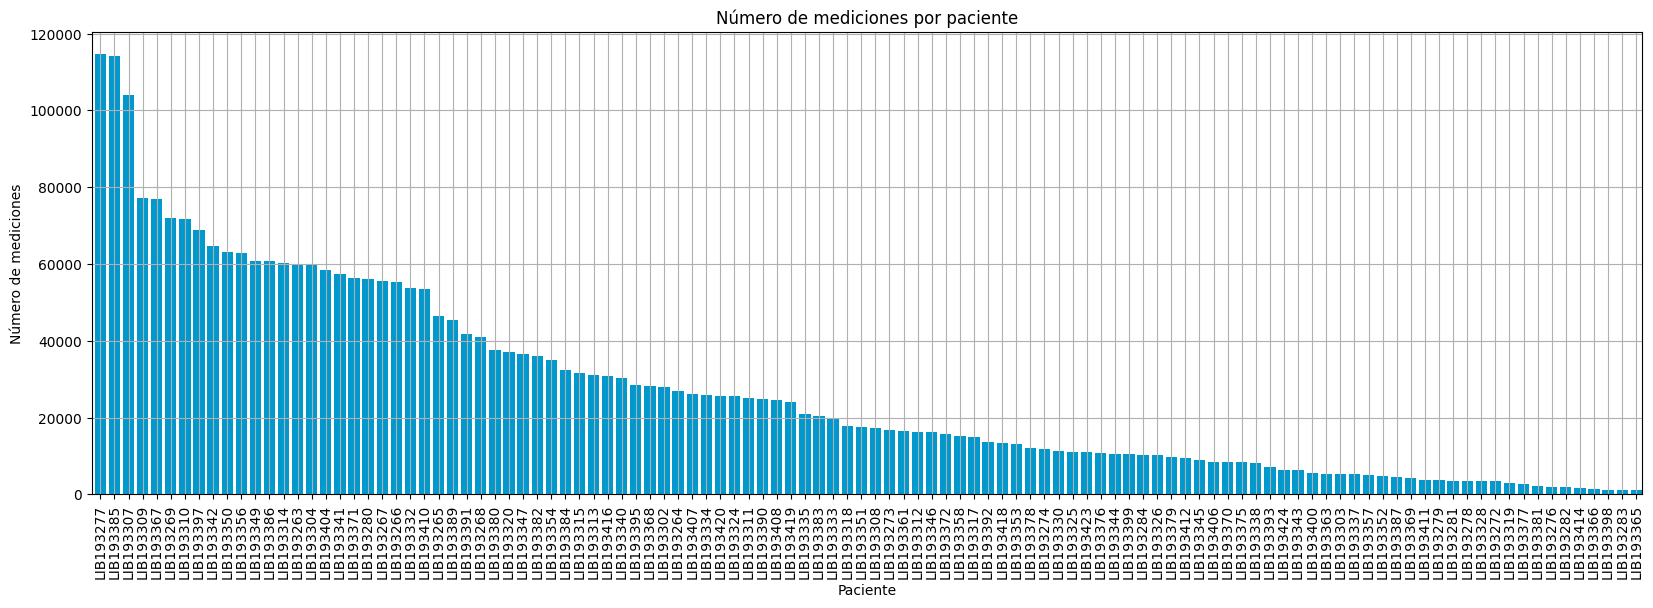

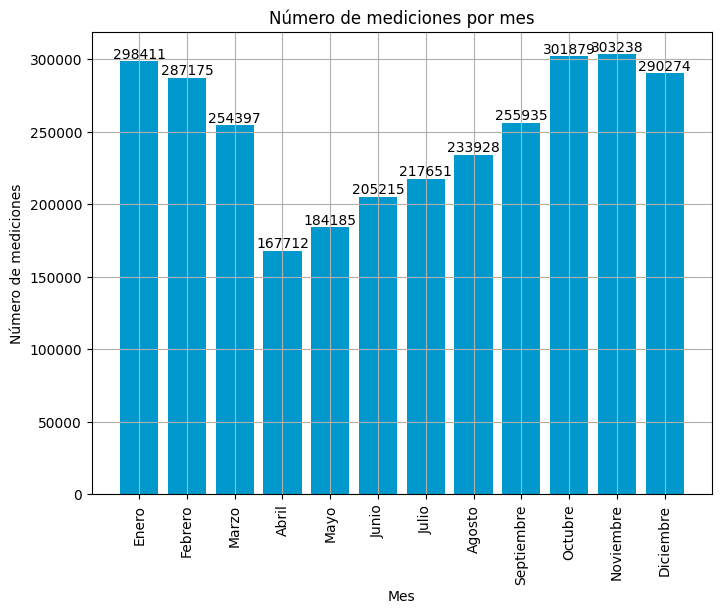

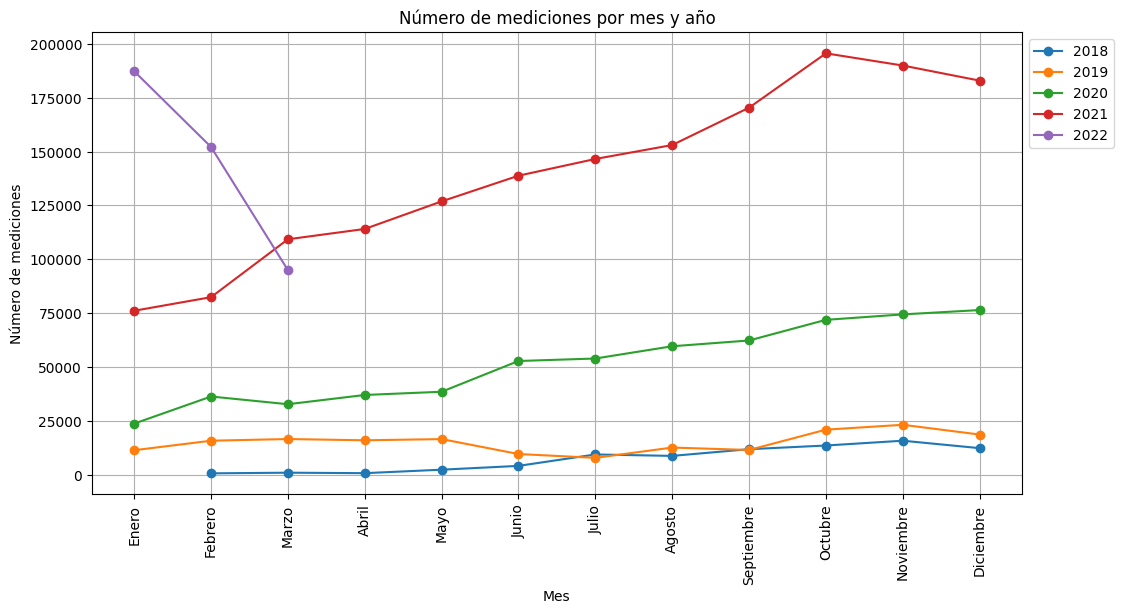

C:\Users\XCoret\AppData\Local\Temp\ipykernel_34032\3788687638.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['Measurement_time'] = pd.to_datetime(dataframe['Measurement_time'])


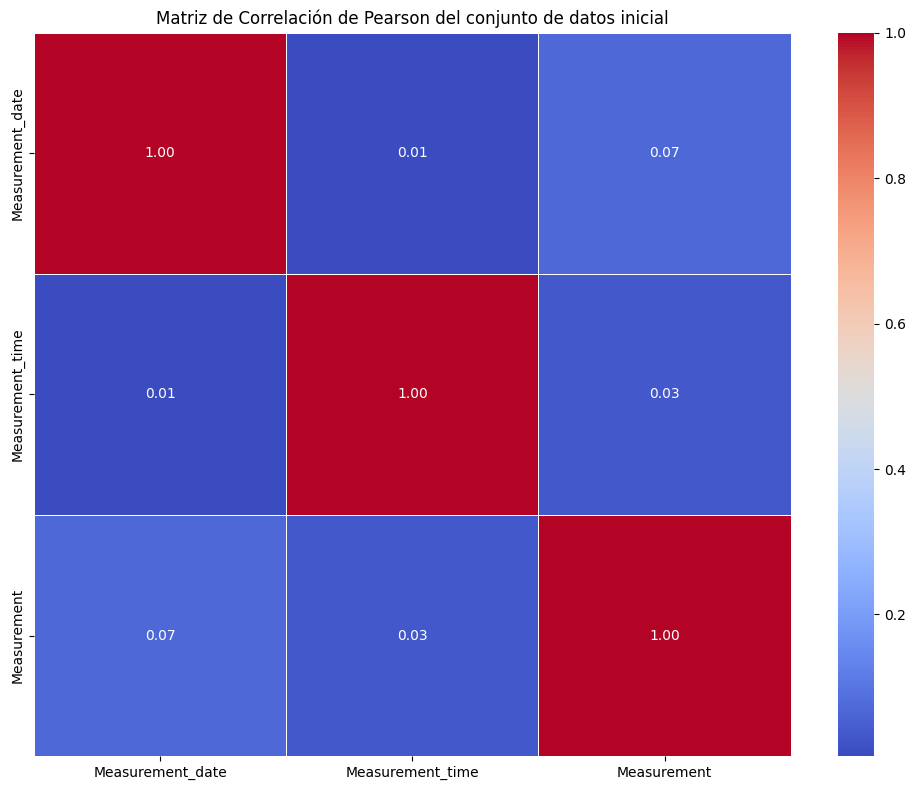

Añadiendo variables inferidas de la medición:
	"Difference", "Trend", "Diagnostic"
Añadiendo variables inferidas de la fecha:
	"Year", "Month", "Day", "Weekday"
Añadiendo variables inferidas de la hora:
	"Hour", "Minute", "Daytime"
Añadiendo fecha y hora en formato Unix:
	"Unix_datetime"
Añadiendo diferencia de tiempo entre registros anteriores por paciente:
	"Time_diff"


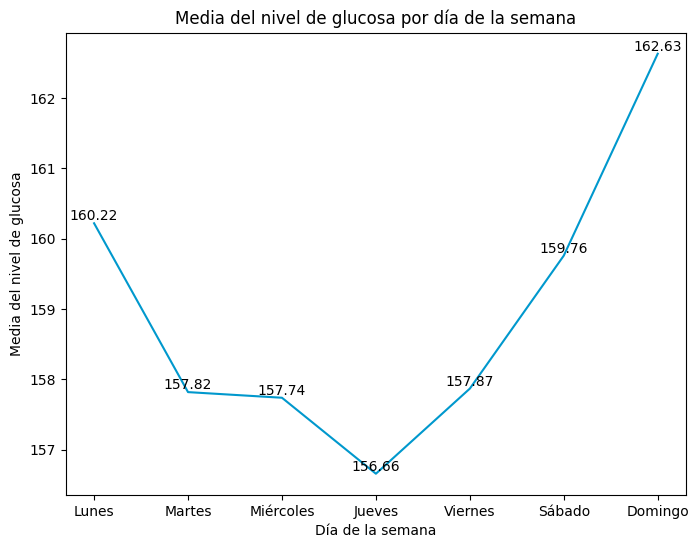

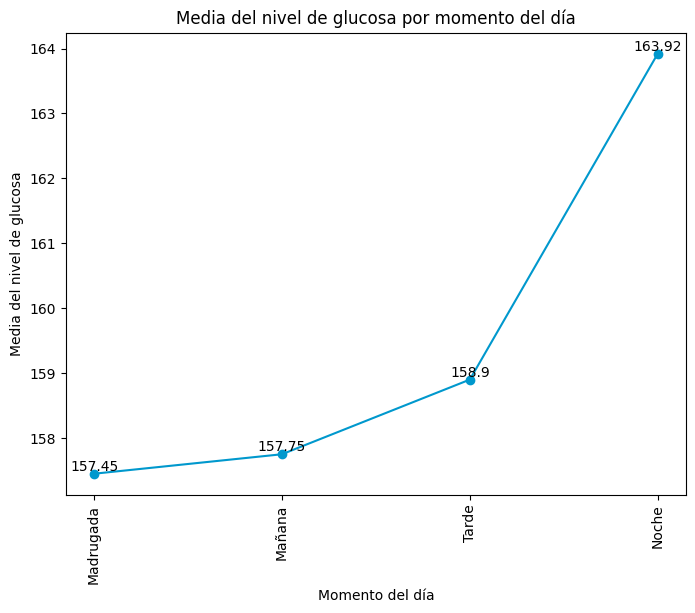

C:\Users\XCoret\AppData\Local\Temp\ipykernel_34032\3788687638.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['Measurement_time'] = pd.to_datetime(dataframe['Measurement_time'])


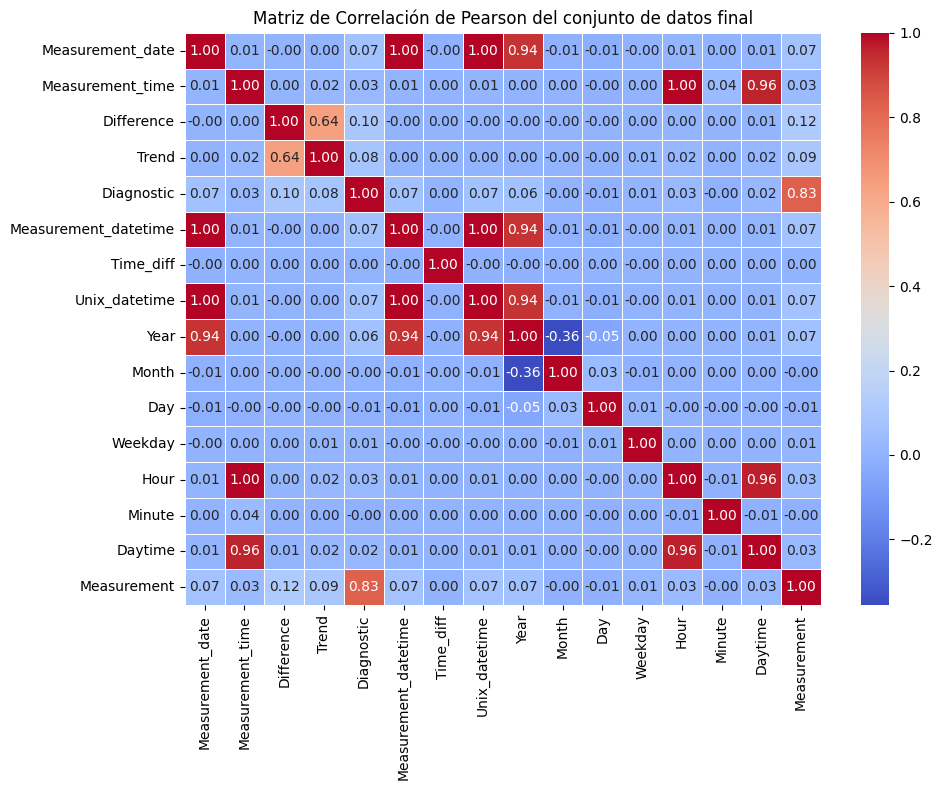

Creando series temporales

===== Caso1 =====
Variables usadas: ['Measurement']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.14565217 0.15217391 0.15652174 0.19565217 0.2326087  0.23478261
 0.21521739 0.21086957 0.21304348 0.18913043 0.17826087 0.19782609]
Etiqueta: 0.19782608695652176

 - Secuencias de validación: 21070 (10%) - Etiquetas de validación: 21070
Primera secuencia: 
[0.11304348 0.10434783 0.09782609 0.1173913  0.14782609 0.14130435
 0.12608696 0.13043478 0.12391304 0.1173913  0.10869565 0.12173913]
Etiqueta: 0.12173913043478263

 - Secuencias de prueba: 21070 (10%) - Etiquetas de prueba: 21070
Primera secuencia: 
[0.27173913 0.2673913  0.26086957 0.25217391 0.24347826 0.22608696
 0.2326087  0.23695652 0.19782609 0.15217391 0.1173913  0.1       ]
Etiqueta: 0.1


==== Primer modelo (C1_M1) ====

Model: "sequential"


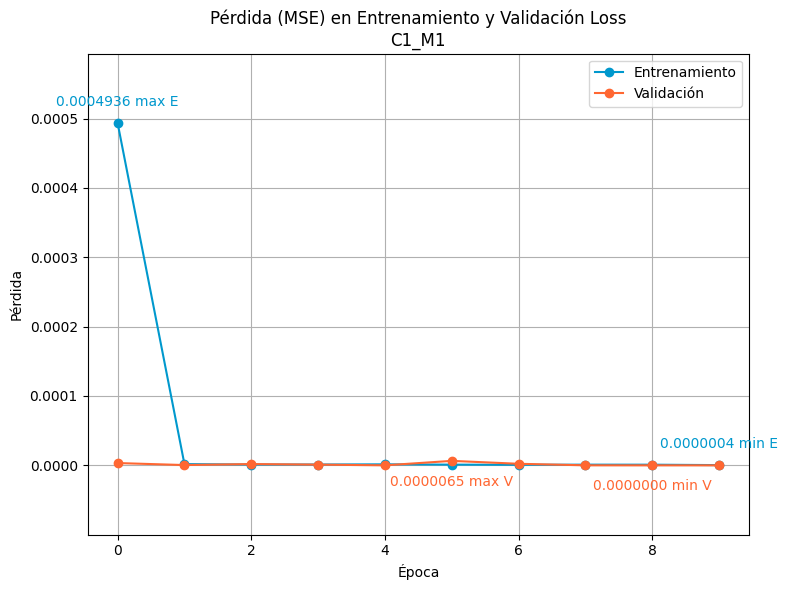


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 5.7895e-09
Pérdida (MSE) : 5.7895488403403306e-09
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.001225035328811725
Raíz del Error Cuadrático Medio (RMSE): 0.03500050469367156
Error Absoluto Medio (MAE): 0.027018596031791995
Puntuación R^2: 0.9999997059001454


<Figure size 640x480 with 0 Axes>

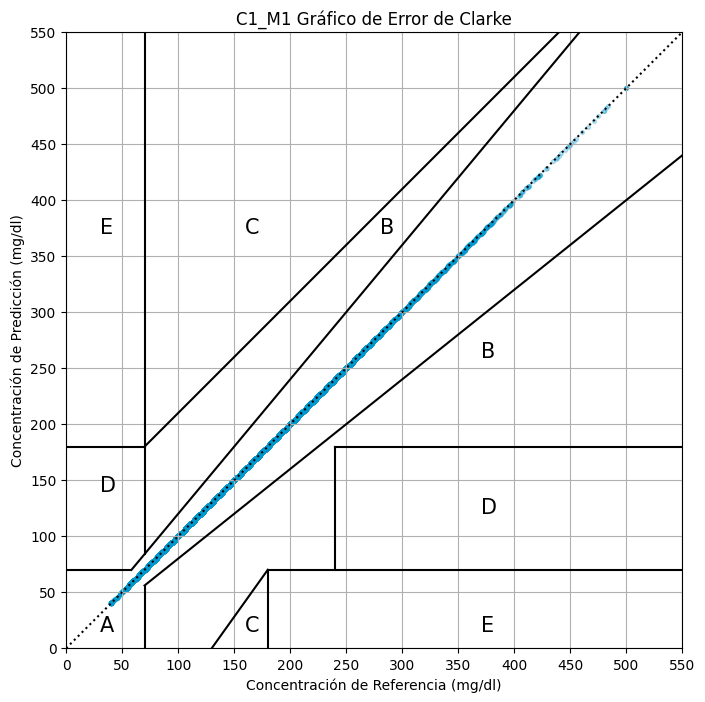

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C1_M2) ====

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 12, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 128)               197632    
            

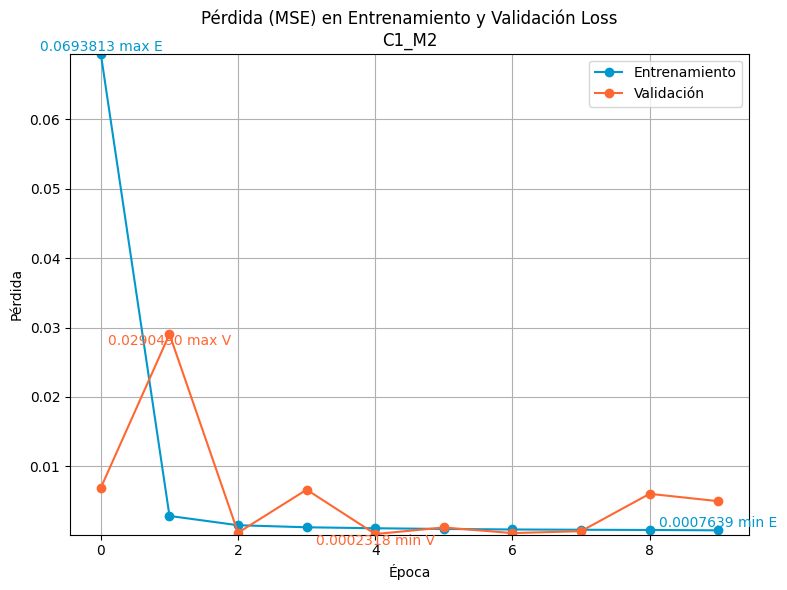


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 0.0050
Pérdida (MSE) : 0.004986352287232876
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 1055.111953245268
Raíz del Error Cuadrático Medio (RMSE): 32.4824868697775
Error Absoluto Medio (MAE): 32.34003430363348
Puntuación R^2: 0.746694430137206


<Figure size 640x480 with 0 Axes>

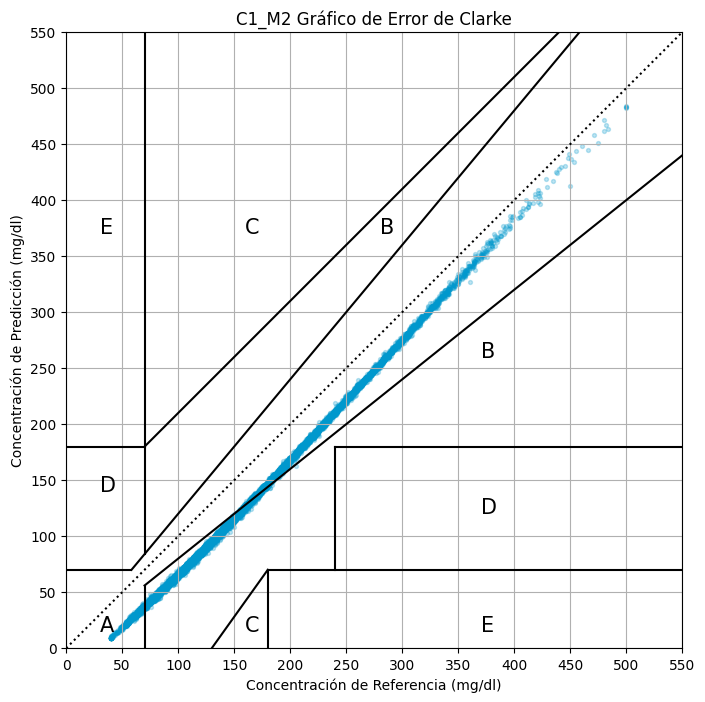

Región A: 9185 puntos (43.59%) dentro del 20% del sensor de referencia
Región B: 11885 puntos (56.41%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C1_M3) ====

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 128)               67072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
        

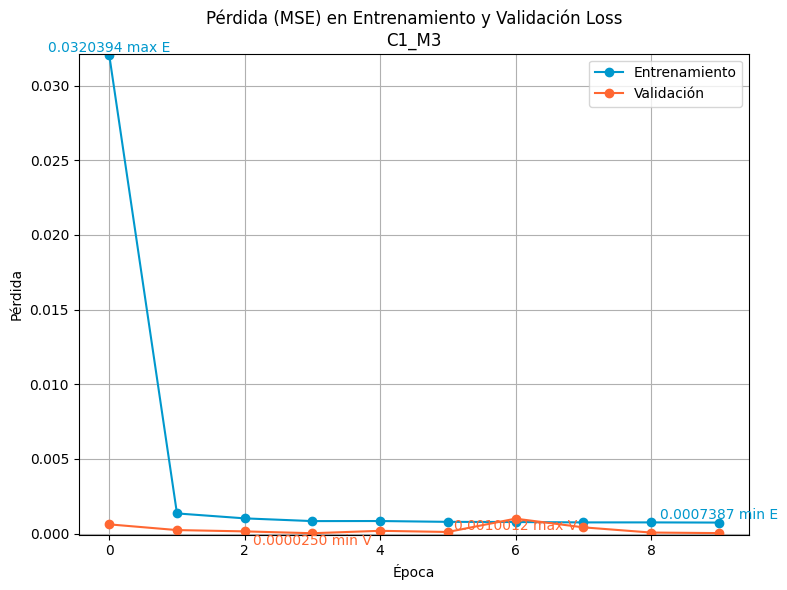


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 3.3572e-05
Pérdida (MSE) : 3.3571795938769355e-05
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 7.1037928601593165
Raíz del Error Cuadrático Medio (RMSE): 2.6652941413959015
Error Absoluto Medio (MAE): 2.0419958903091335
Puntuación R^2: 0.9982945598397447


<Figure size 640x480 with 0 Axes>

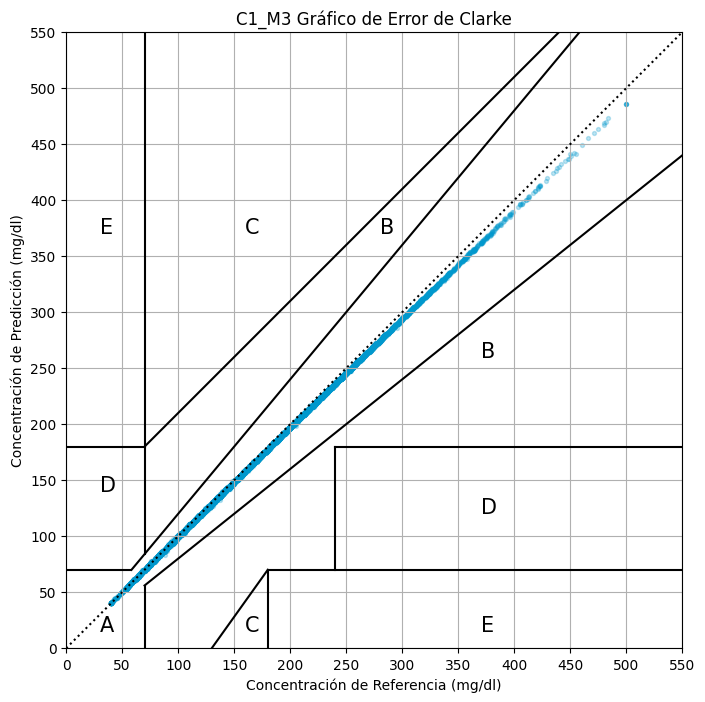

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso2 =====
Variables usadas: ['Month', 'Day']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.63636364 0.16666667 0.14565217 0.63636364 0.16666667 0.15217391
 0.63636364 0.16666667 0.15652174 0.63636364 0.16666667 0.19565217
 0.63636364 0.16666667 0.2326087  0.63636364 0.16666667 0.23478261
 0.63636364 0.16666667 0.21521739 0.63636364 0.16666667 0.21086957
 0.6

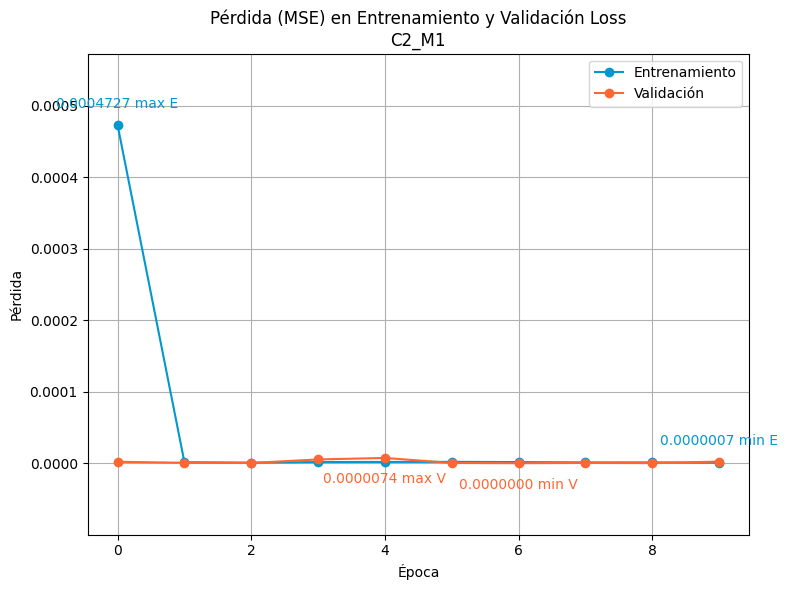


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 2.3003e-06
Pérdida (MSE) : 2.300278993061511e-06
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.48673880388409746
Raíz del Error Cuadrático Medio (RMSE): 0.6976666853764034
Error Absoluto Medio (MAE): 0.628446540235057
Puntuación R^2: 0.9998831463810898


<Figure size 640x480 with 0 Axes>

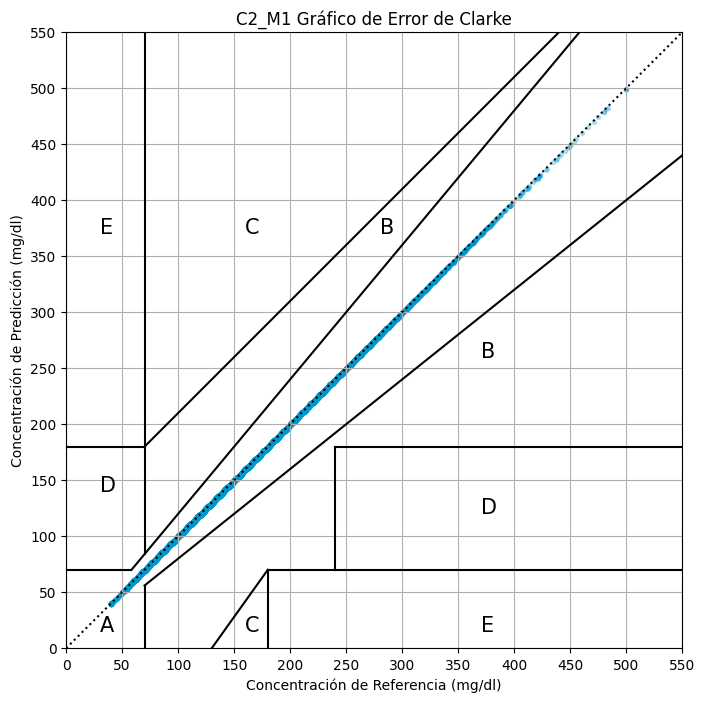

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C2_M2) ====

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 12, 256)           267264    
                                                                 
 dropout_8 (Dropout)         (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_6 (CuDNNLSTM)    (None, 128)               197632    
            

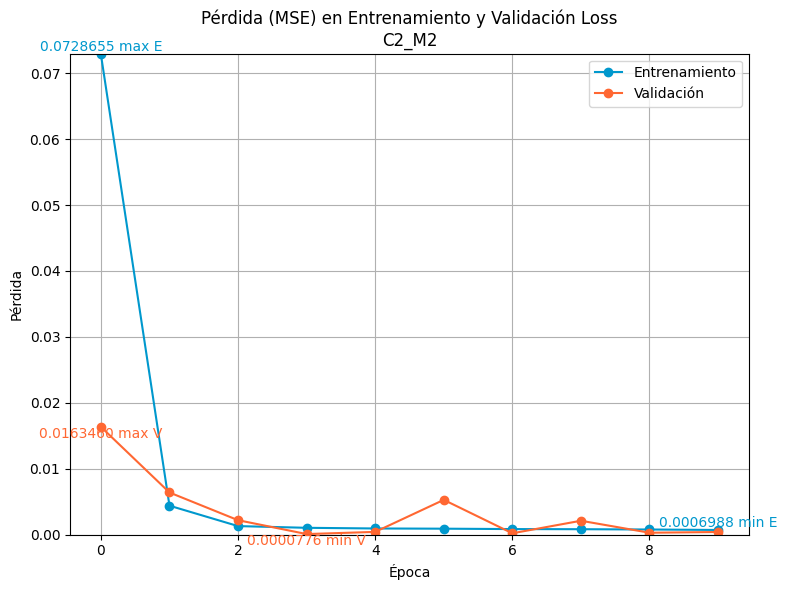


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 3.8874e-04
Pérdida (MSE) : 0.00038873657467775047
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 82.25669627433237
Raíz del Error Cuadrático Medio (RMSE): 9.069547743649204
Error Absoluto Medio (MAE): 8.962329654304348
Puntuación R^2: 0.9802522573450961


<Figure size 640x480 with 0 Axes>

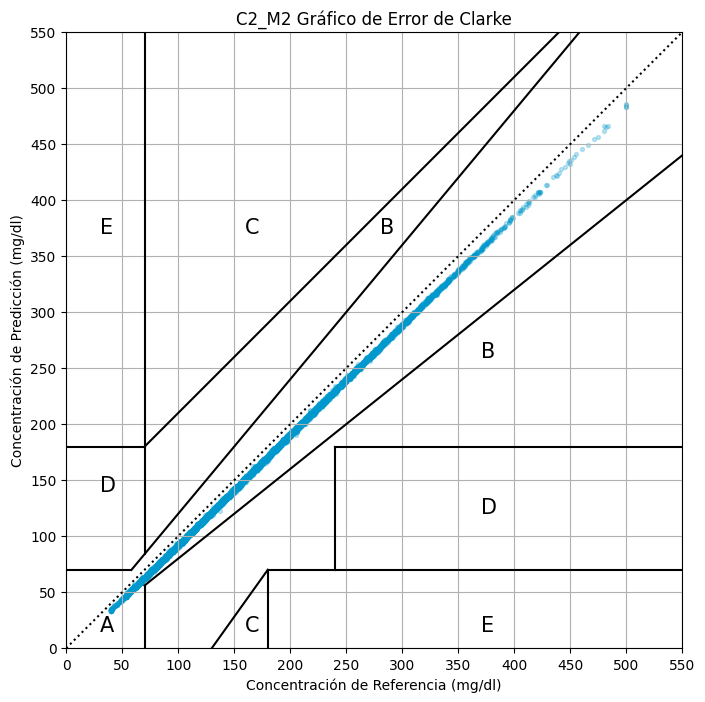

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C2_M3) ====

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 128)               68096     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
             

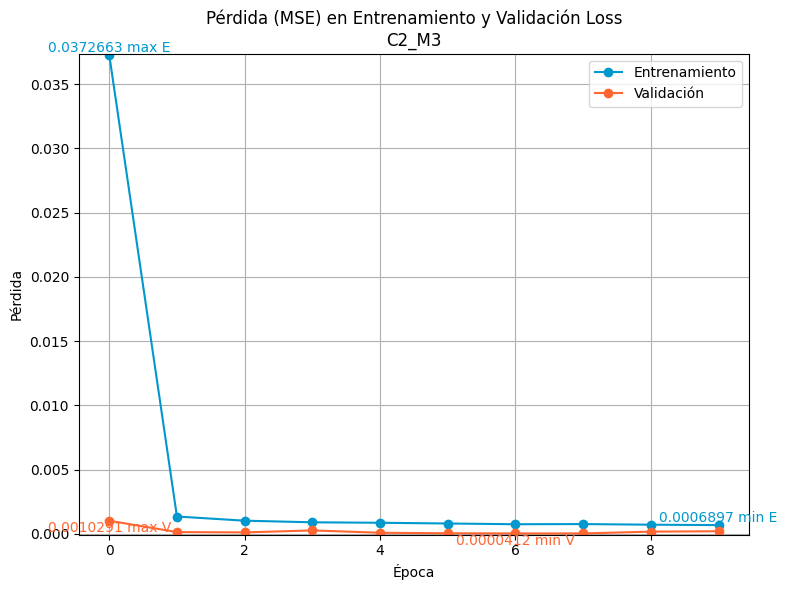


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 2.0652e-04
Pérdida (MSE) : 0.0002065224980469793
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 43.70019808835249
Raíz del Error Cuadrático Medio (RMSE): 6.61061253503429
Error Absoluto Medio (MAE): 5.064970194269368
Puntuación R^2: 0.9895086928492849


<Figure size 640x480 with 0 Axes>

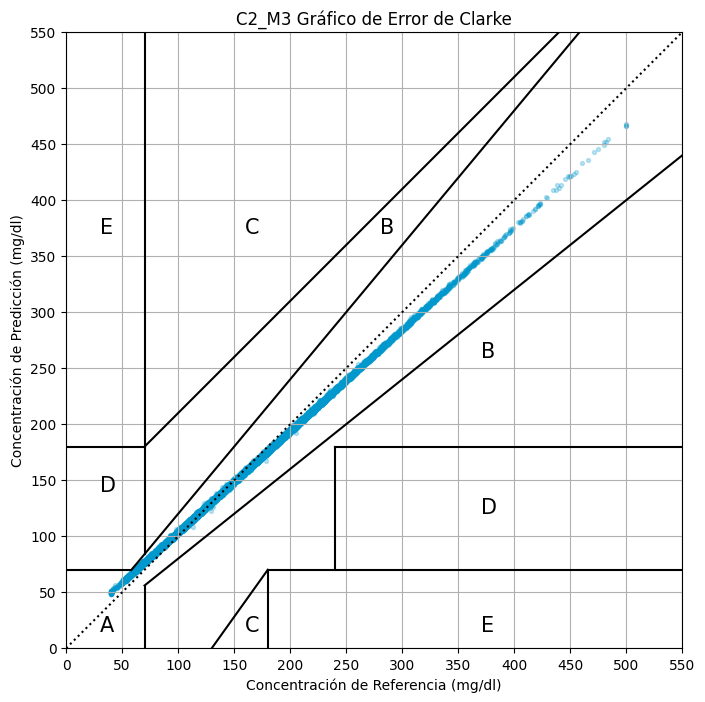

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso3 =====
Variables usadas: ['Weekday']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.5        0.14565217 0.5        0.15217391 0.5        0.15652174
 0.5        0.19565217 0.5        0.2326087  0.5        0.23478261
 0.5        0.21521739 0.5        0.21086957 0.5        0.21304348
 0.5        0.18913043 0.5        0.17826087 0.5        0.19782609]
Etiqueta

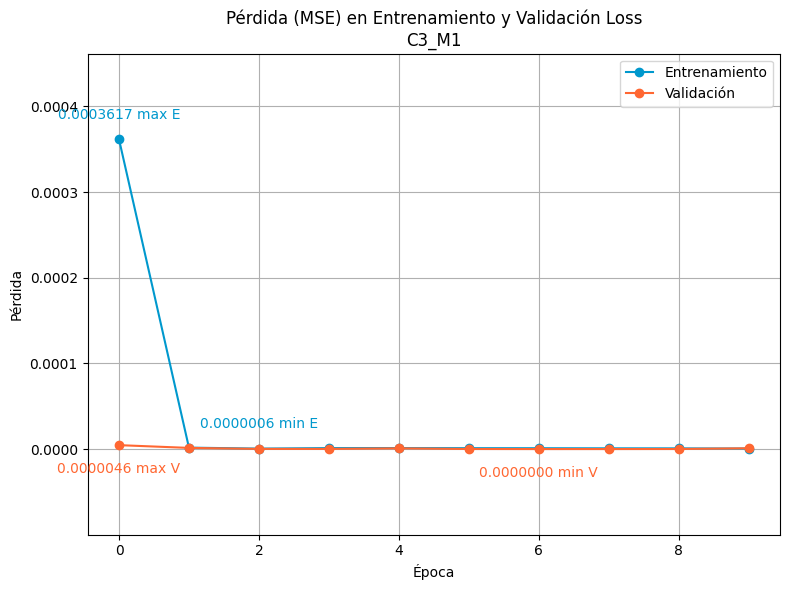


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 9.6592e-07
Pérdida (MSE) : 9.659220268076751e-07
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.20438903556488303
Raíz del Error Cuadrático Medio (RMSE): 0.45209405610434983
Error Absoluto Medio (MAE): 0.41026072418401355
Puntuación R^2: 0.9999509313860314


<Figure size 640x480 with 0 Axes>

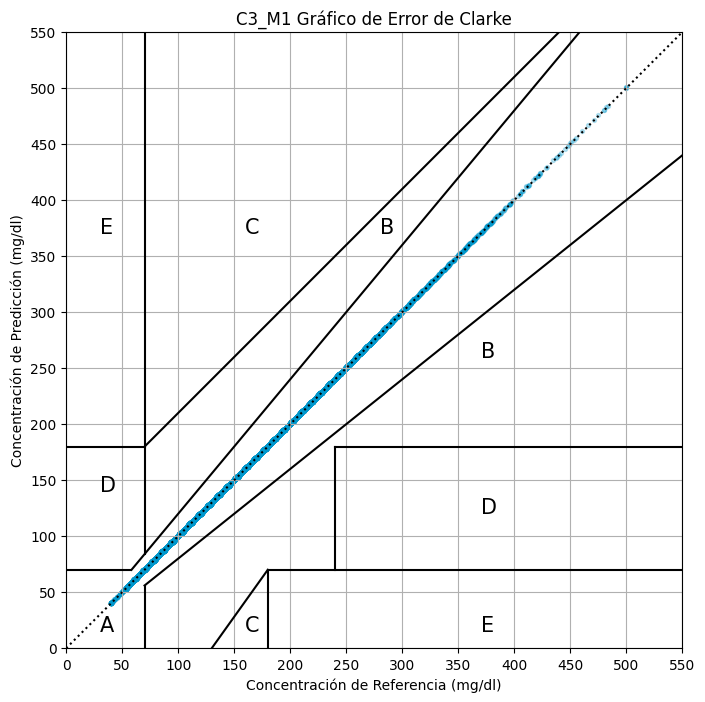

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C3_M2) ====

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_9 (CuDNNLSTM)    (None, 12, 256)           266240    
                                                                 
 dropout_16 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_10 (CuDNNLSTM)   (None, 128)               197632    
            

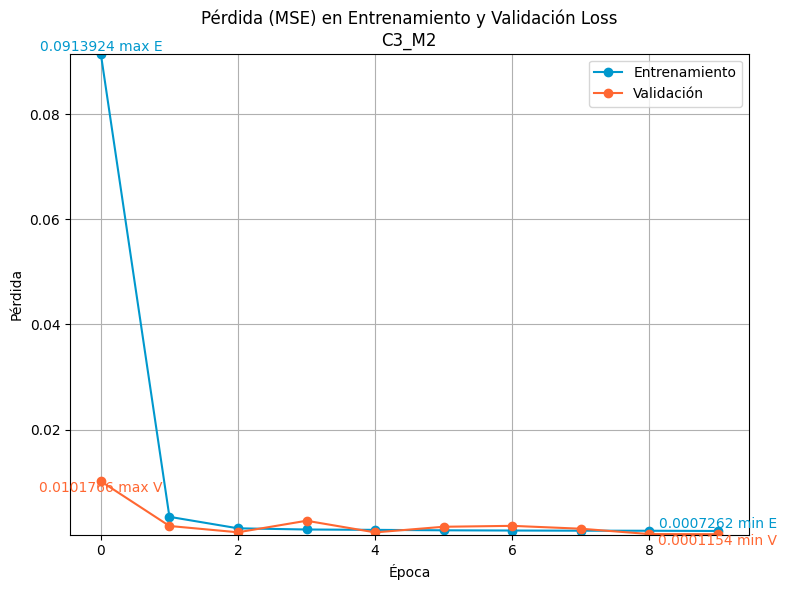


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 1.1268e-04
Pérdida (MSE) : 0.00011267794616287574
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 23.842660225773322
Raíz del Error Cuadrático Medio (RMSE): 4.882894656428021
Error Absoluto Medio (MAE): 3.771244533558732
Puntuación R^2: 0.9942759831153856


<Figure size 640x480 with 0 Axes>

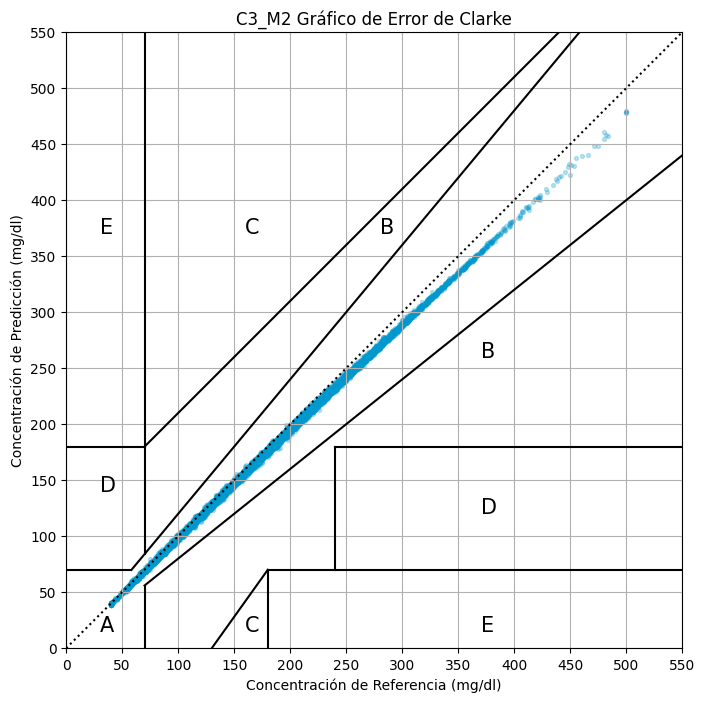

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C3_M3) ====

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_11 (CuDNNLSTM)   (None, 128)               67584     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               33024     
             

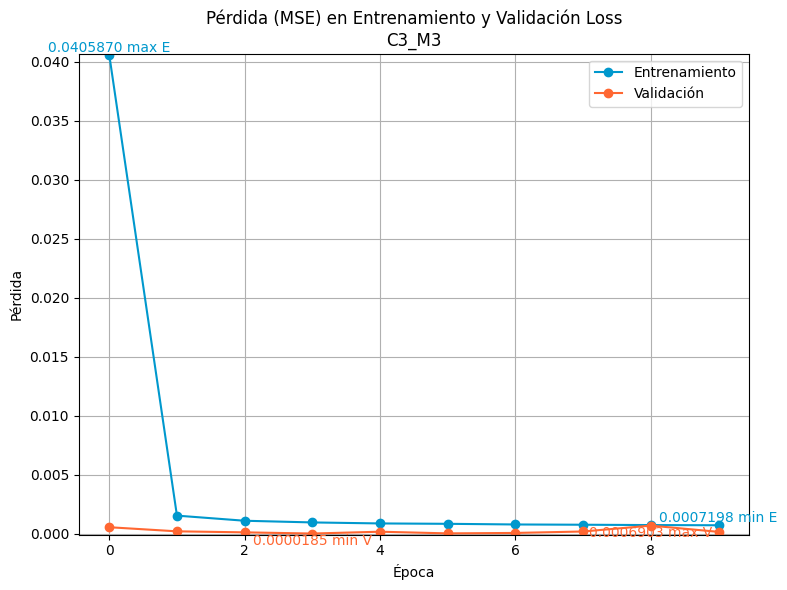


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 1.5826e-04
Pérdida (MSE) : 0.0001582609984325245
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 33.48802536652212
Raíz del Error Cuadrático Medio (RMSE): 5.786883908160084
Error Absoluto Medio (MAE): 4.517422153036574
Puntuación R^2: 0.9919603760312298


<Figure size 640x480 with 0 Axes>

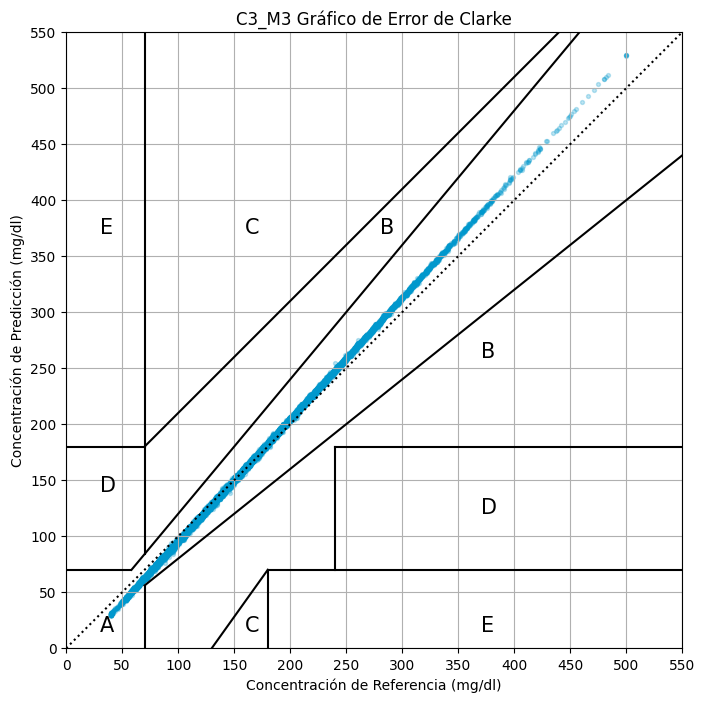

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso4 =====
Variables usadas: ['Hour', 'Minute']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.7826087  0.06779661 0.14565217 0.7826087  0.3220339  0.15217391
 0.7826087  0.57627119 0.15652174 0.7826087  0.83050847 0.19565217
 0.82608696 0.06779661 0.2326087  0.82608696 0.3220339  0.23478261
 0.82608696 0.57627119 0.21521739 0.82608696 0.83050847 0.21086957
 0

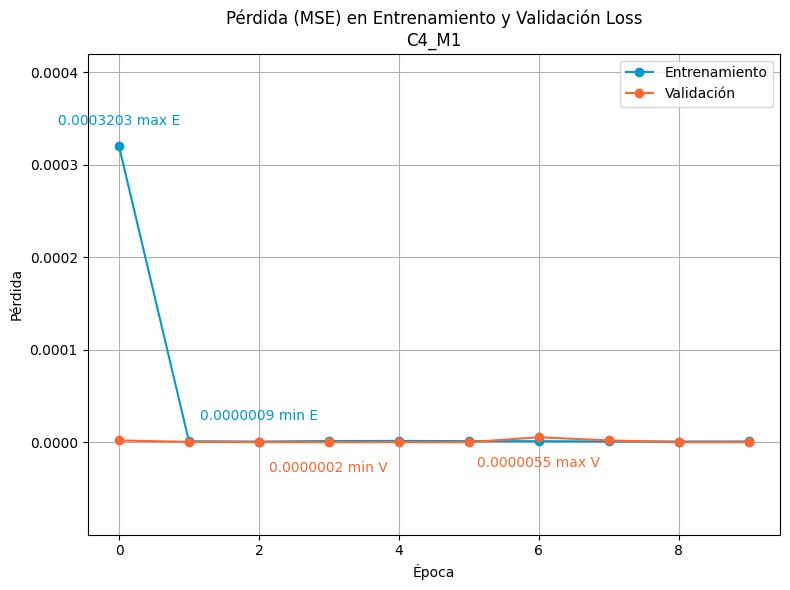


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 3.0427e-07
Pérdida (MSE) : 3.042697471755673e-07
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.06438341050121688
Raíz del Error Cuadrático Medio (RMSE): 0.25373886281217717
Error Absoluto Medio (MAE): 0.24340907107273266
Puntuación R^2: 0.9999845431791038


<Figure size 640x480 with 0 Axes>

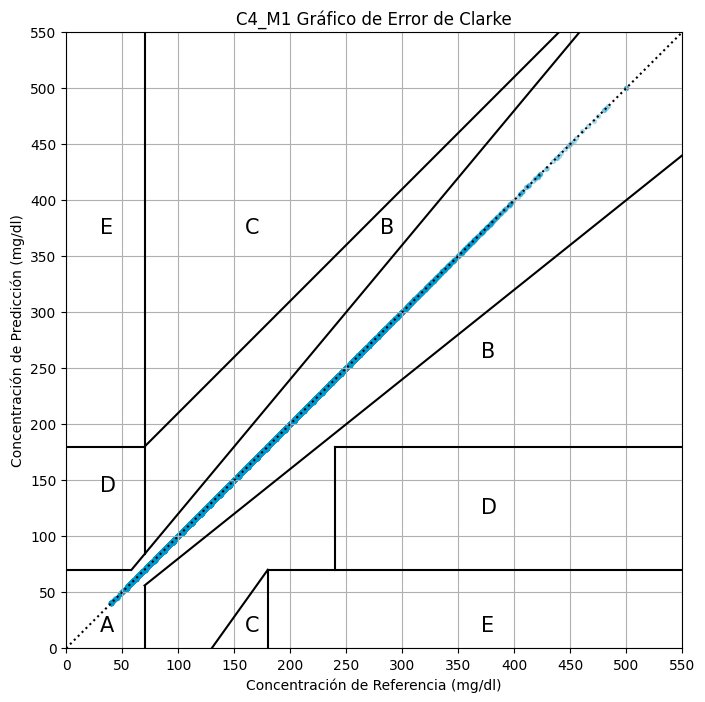

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C4_M2) ====

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_13 (CuDNNLSTM)   (None, 12, 256)           267264    
                                                                 
 dropout_24 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_14 (CuDNNLSTM)   (None, 128)               197632    
           

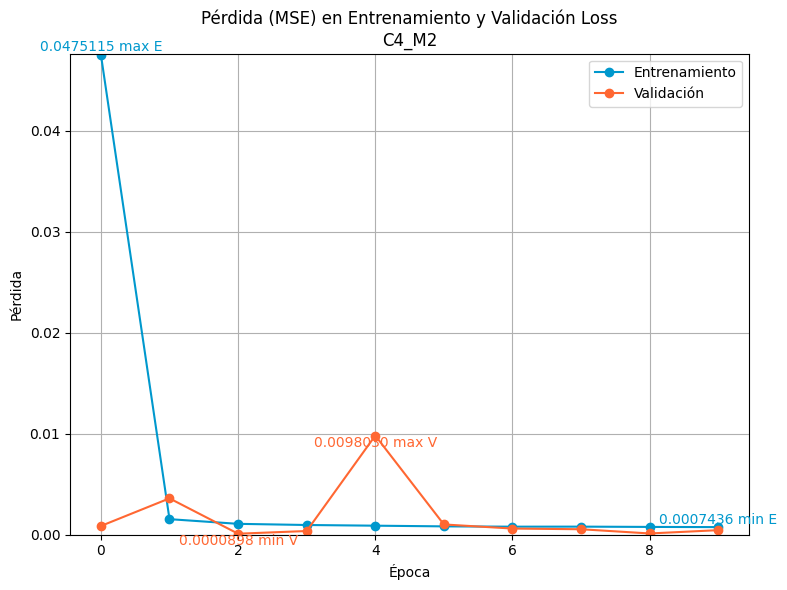


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 4.4577e-04
Pérdida (MSE) : 0.0004457695467863232
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 94.32483628919287
Raíz del Error Cuadrático Medio (RMSE): 9.712097419671657
Error Absoluto Medio (MAE): 9.033792384020458
Puntuación R^2: 0.9773550035757251


<Figure size 640x480 with 0 Axes>

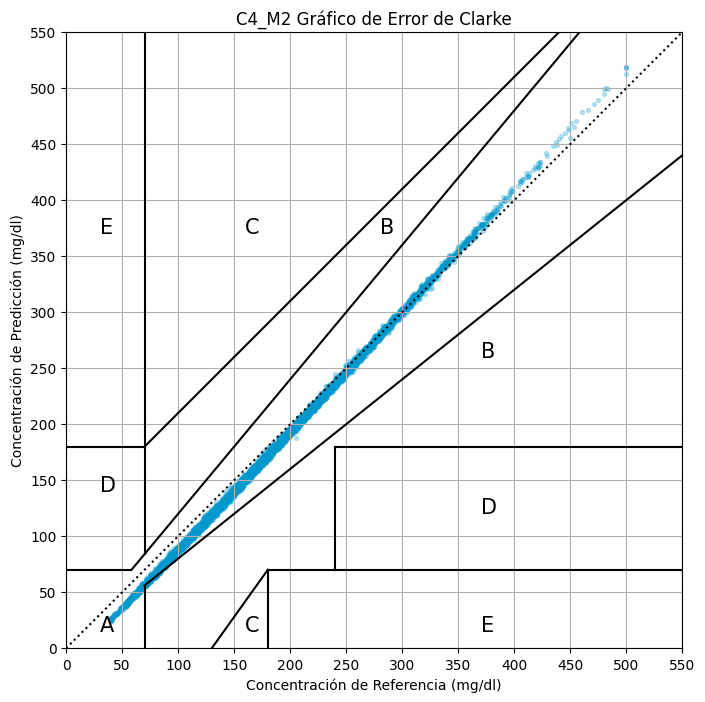

Región A: 21044 puntos (99.88%) dentro del 20% del sensor de referencia
Región B: 26 puntos (0.12%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C4_M3) ====

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_15 (CuDNNLSTM)   (None, 128)               68096     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 256)               33024     
          

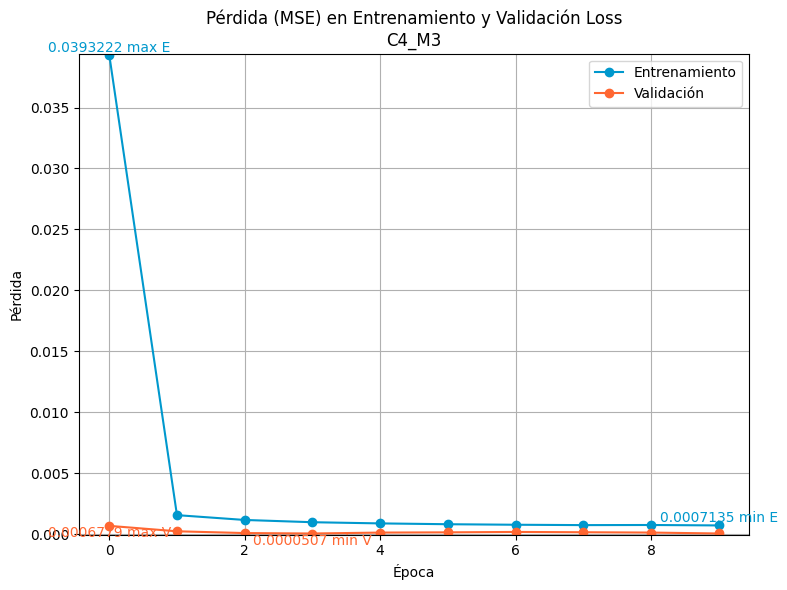


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 5.0913e-05
Pérdida (MSE) : 5.091322964290157e-05
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 10.773228875432999
Raíz del Error Cuadrático Medio (RMSE): 3.2822597208985456
Error Absoluto Medio (MAE): 2.4304882131032506
Puntuación R^2: 0.9974136214918613


<Figure size 640x480 with 0 Axes>

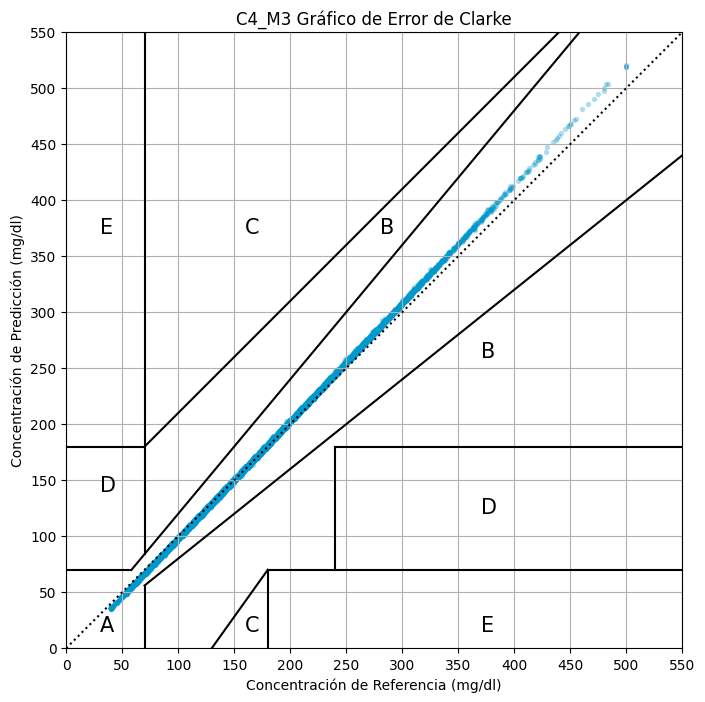

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso5 =====
Variables usadas: ['Daytime']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.66666667 0.14565217 0.66666667 0.15217391 0.66666667 0.15652174
 0.66666667 0.19565217 0.66666667 0.2326087  0.66666667 0.23478261
 0.66666667 0.21521739 0.66666667 0.21086957 1.         0.21304348
 1.         0.18913043 1.         0.17826087 1.         0.19782609]
Etiqueta

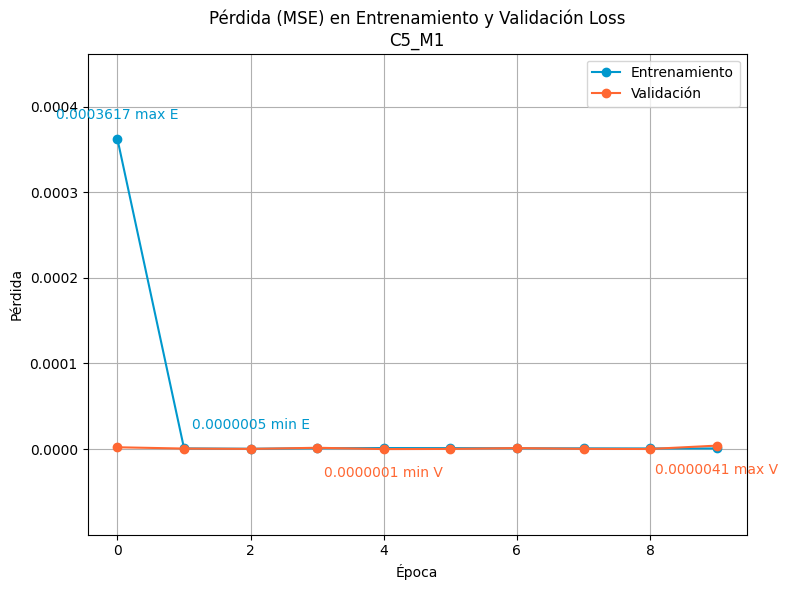


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 4.1037e-06
Pérdida (MSE) : 4.1037033042812254e-06
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.868343767839451
Raíz del Error Cuadrático Medio (RMSE): 0.9318496487306581
Error Absoluto Medio (MAE): 0.8803462967693851
Puntuación R^2: 0.9997915327257237


<Figure size 640x480 with 0 Axes>

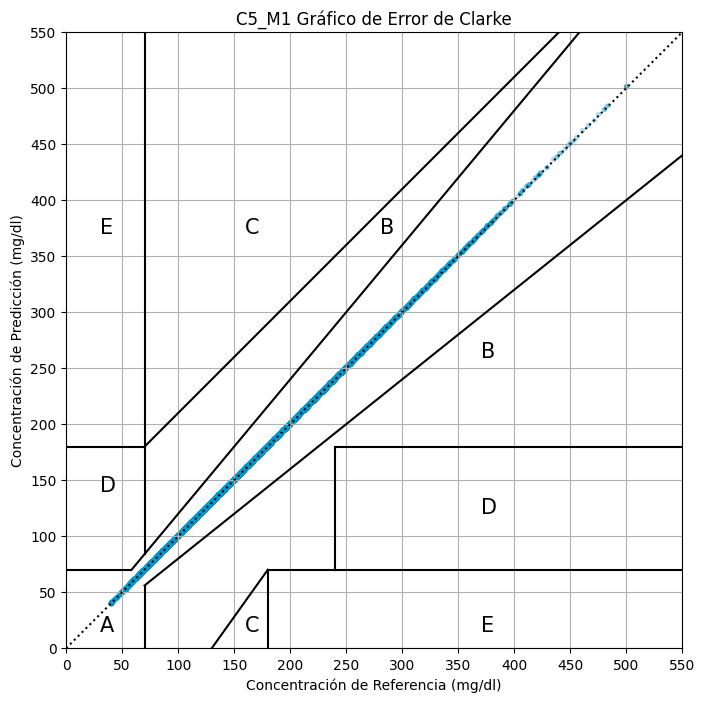

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C5_M2) ====

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_17 (CuDNNLSTM)   (None, 12, 256)           266240    
                                                                 
 dropout_32 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_18 (CuDNNLSTM)   (None, 128)               197632    
           

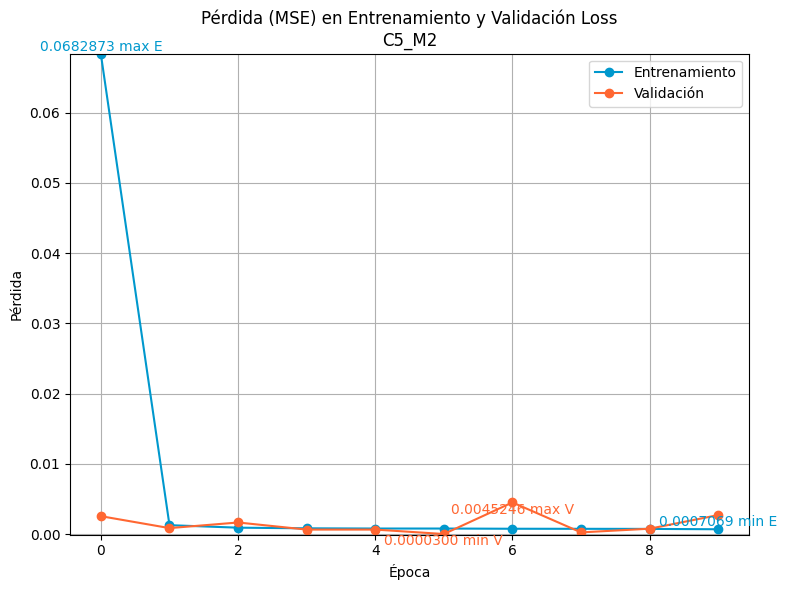


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 0.0027
Pérdida (MSE) : 0.0027291979640722275
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 577.4982875076548
Raíz del Error Cuadrático Medio (RMSE): 24.031194050809354
Error Absoluto Medio (MAE): 23.94260906976266
Puntuación R^2: 0.8613573352458177


<Figure size 640x480 with 0 Axes>

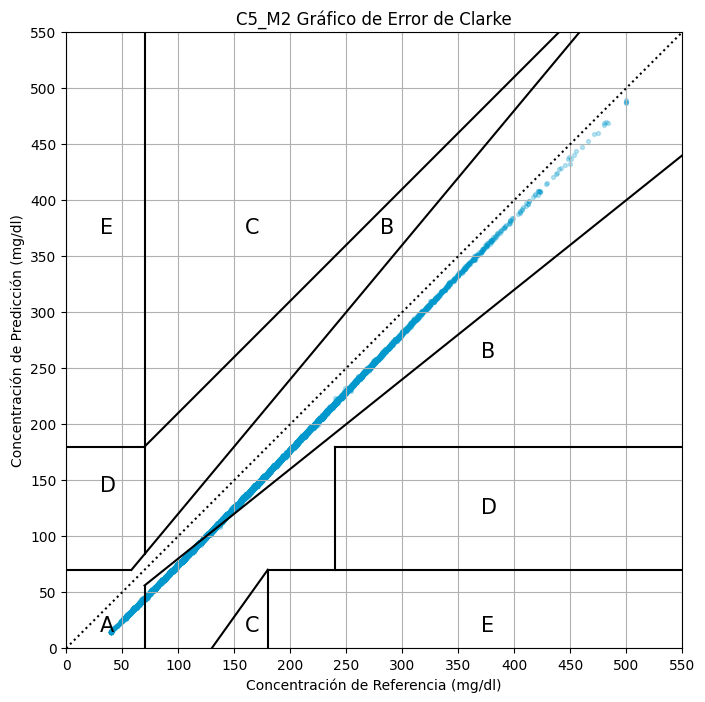

Región A: 14523 puntos (68.93%) dentro del 20% del sensor de referencia
Región B: 6547 puntos (31.07%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C5_M3) ====

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_19 (CuDNNLSTM)   (None, 128)               67584     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 256)               33024     
       

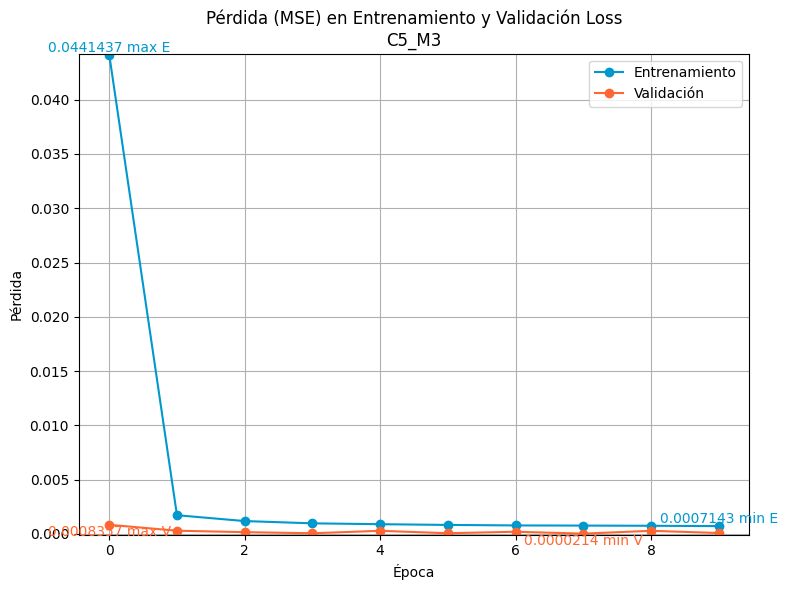


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 7.9522e-05
Pérdida (MSE) : 7.952232408570126e-05
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 16.826920366983856
Raíz del Error Cuadrático Medio (RMSE): 4.102062940397655
Error Absoluto Medio (MAE): 3.6881301378377773
Puntuación R^2: 0.9959602839874151


<Figure size 640x480 with 0 Axes>

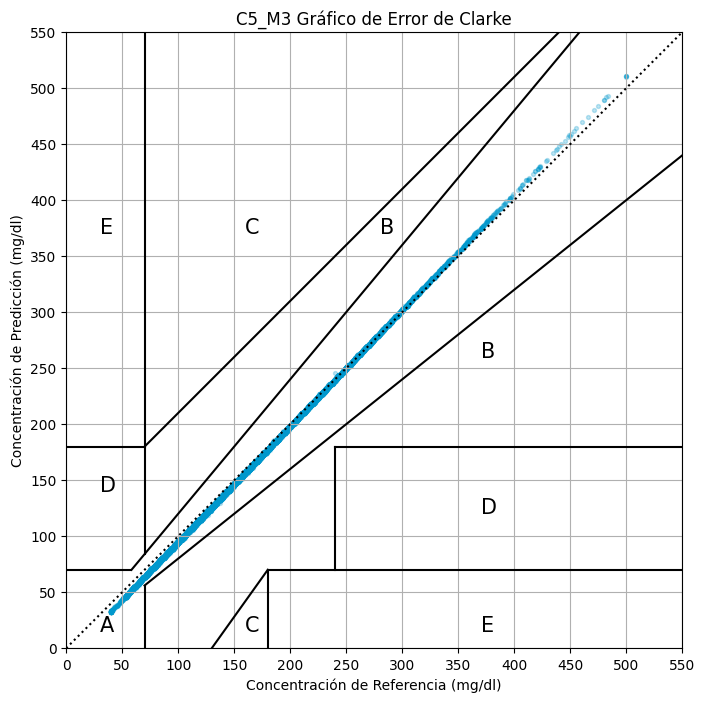

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso6 =====
Variables usadas: ['Trend', 'Diagnostic']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.5        0.5        0.14565217 1.         0.5        0.15217391
 1.         0.5        0.15652174 1.         0.5        0.19565217
 1.         0.5        0.2326087  1.         0.5        0.23478261
 0.         0.5        0.21521739 0.         0.5        0.210869

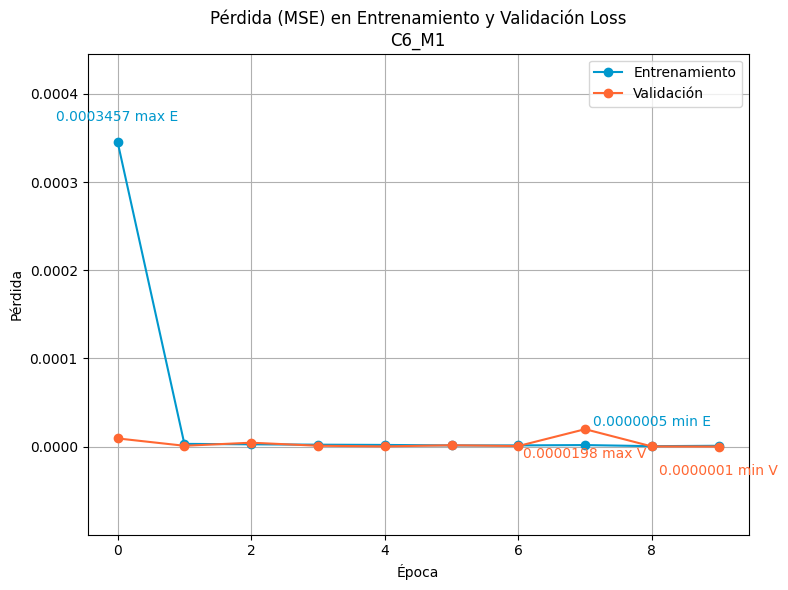


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 7.2951e-08
Pérdida (MSE) : 7.29512024122414e-08
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.015436404488315004
Raíz del Error Cuadrático Medio (RMSE): 0.12424332774163369
Error Absoluto Medio (MAE): 0.10559811585312688
Puntuación R^2: 0.9999962941115172


<Figure size 640x480 with 0 Axes>

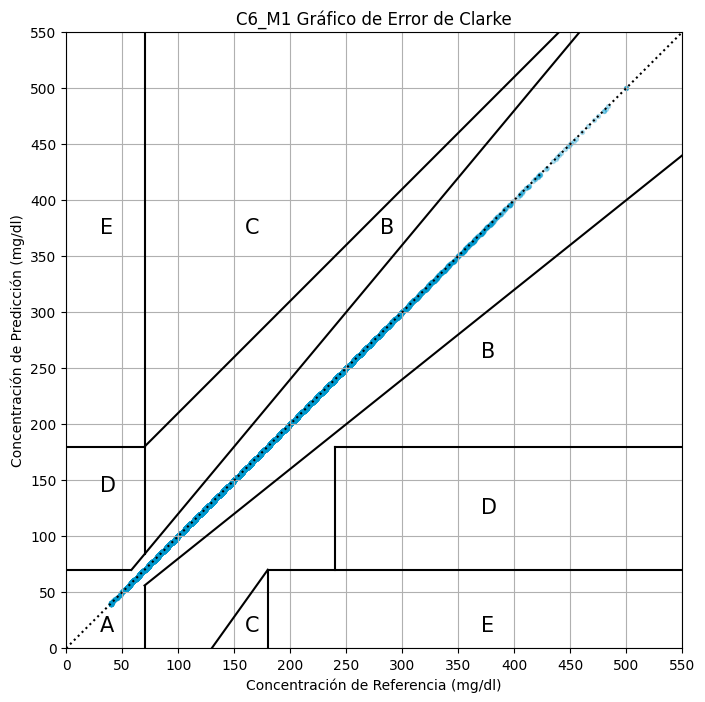

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C6_M2) ====

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_21 (CuDNNLSTM)   (None, 12, 256)           267264    
                                                                 
 dropout_40 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_22 (CuDNNLSTM)   (None, 128)               197632    
           

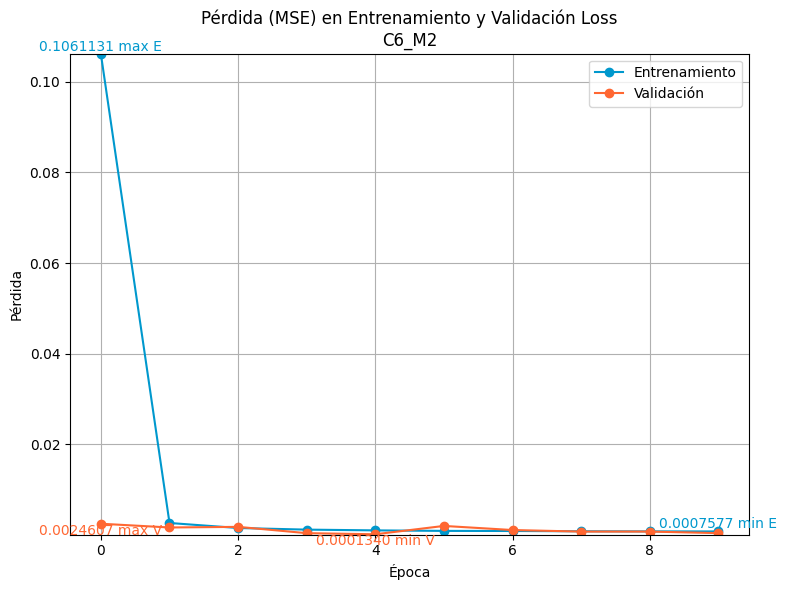


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 3.9063e-04
Pérdida (MSE) : 0.0003906309721060097
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 82.65752031498931
Raíz del Error Cuadrático Medio (RMSE): 9.091618135128053
Error Absoluto Medio (MAE): 8.019739868225619
Puntuación R^2: 0.9801560296777656


<Figure size 640x480 with 0 Axes>

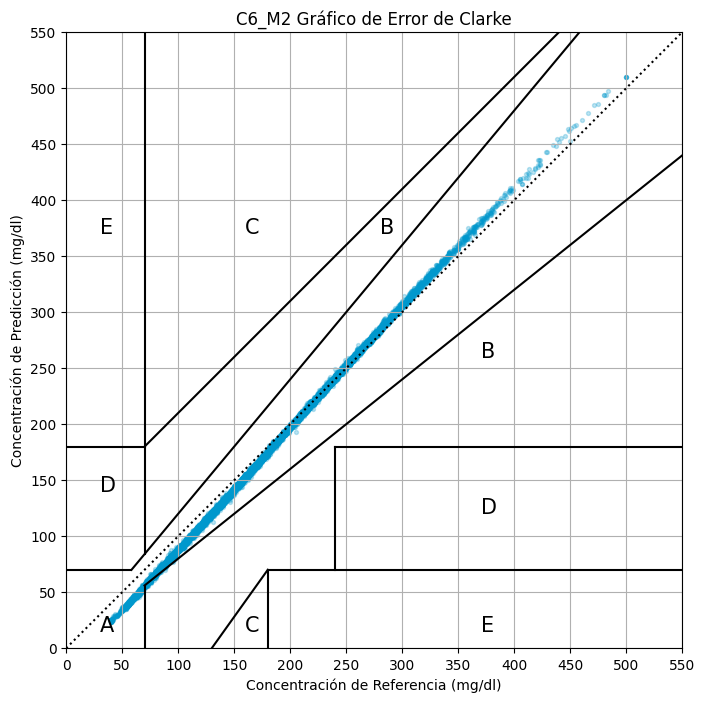

Región A: 21019 puntos (99.76%) dentro del 20% del sensor de referencia
Región B: 51 puntos (0.24%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C6_M3) ====

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_23 (CuDNNLSTM)   (None, 128)               68096     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 256)               33024     
          

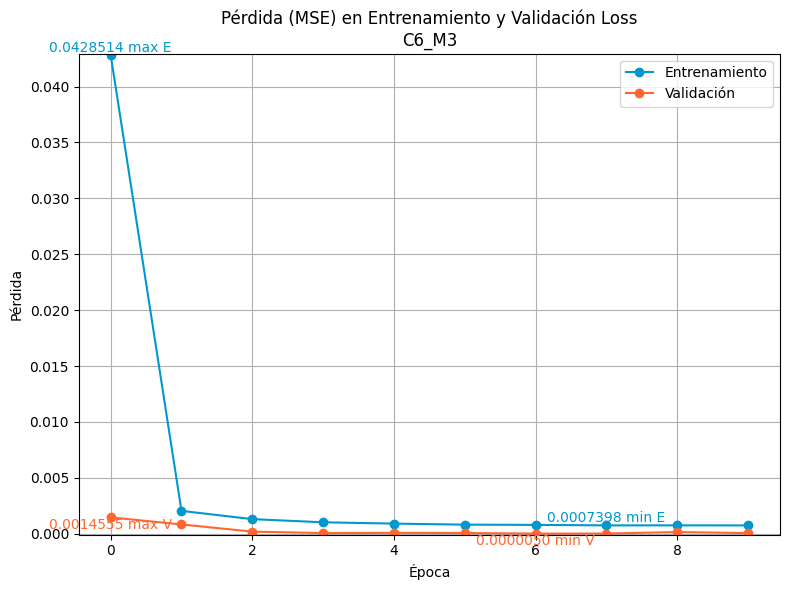


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 4.9490e-05
Pérdida (MSE) : 4.949004505760968e-05
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 10.472089760728934
Raíz del Error Cuadrático Medio (RMSE): 3.2360608400845825
Error Absoluto Medio (MAE): 2.759881932711682
Puntuación R^2: 0.9974859173414377


<Figure size 640x480 with 0 Axes>

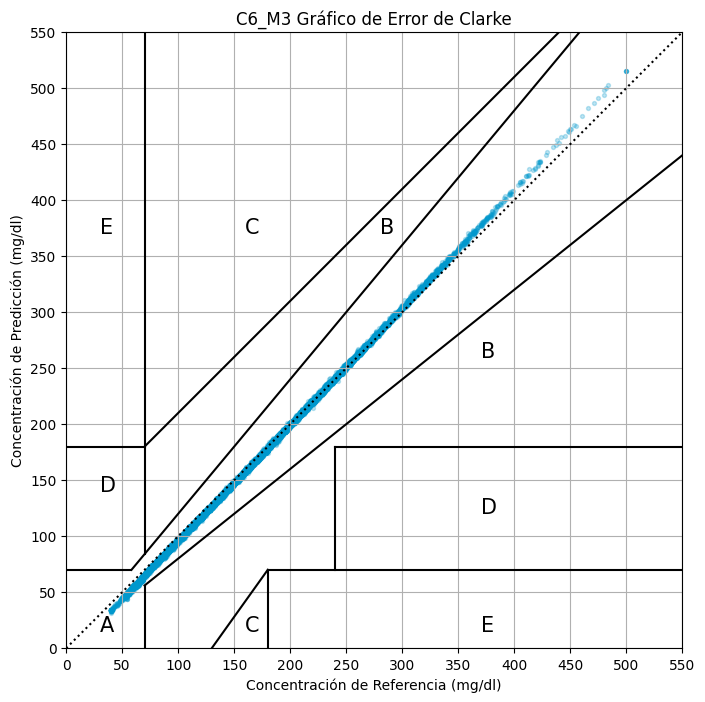

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso7 =====
Variables usadas: ['Difference']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.5        0.14565217 0.50742574 0.15217391 0.5049505  0.15652174
 0.54455446 0.19565217 0.54207921 0.2326087  0.50247525 0.23478261
 0.47772277 0.21521739 0.4950495  0.21086957 0.50247525 0.21304348
 0.47277228 0.18913043 0.48762376 0.17826087 0.52227723 0.19782609]
Etiqu

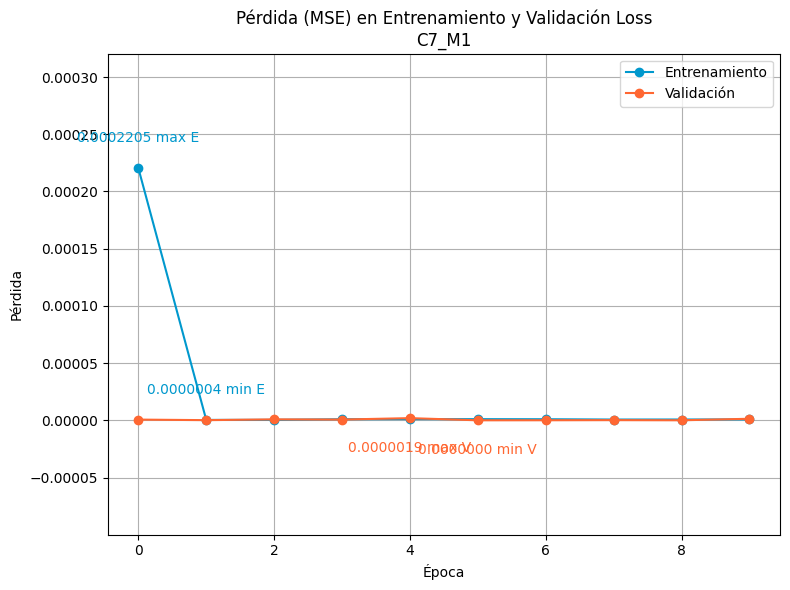


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 1.3656e-06
Pérdida (MSE) : 1.365615162285394e-06
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.28896383459708225
Raíz del Error Cuadrático Medio (RMSE): 0.5375535643980814
Error Absoluto Medio (MAE): 0.4836766516817216
Puntuación R^2: 0.9999306271258067


<Figure size 640x480 with 0 Axes>

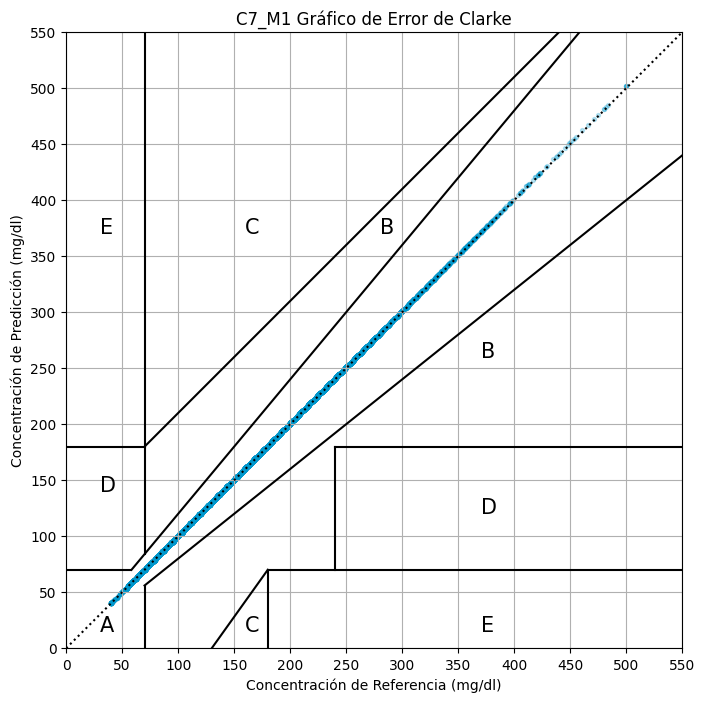

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C7_M2) ====

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_25 (CuDNNLSTM)   (None, 12, 256)           266240    
                                                                 
 dropout_48 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_26 (CuDNNLSTM)   (None, 128)               197632    
           

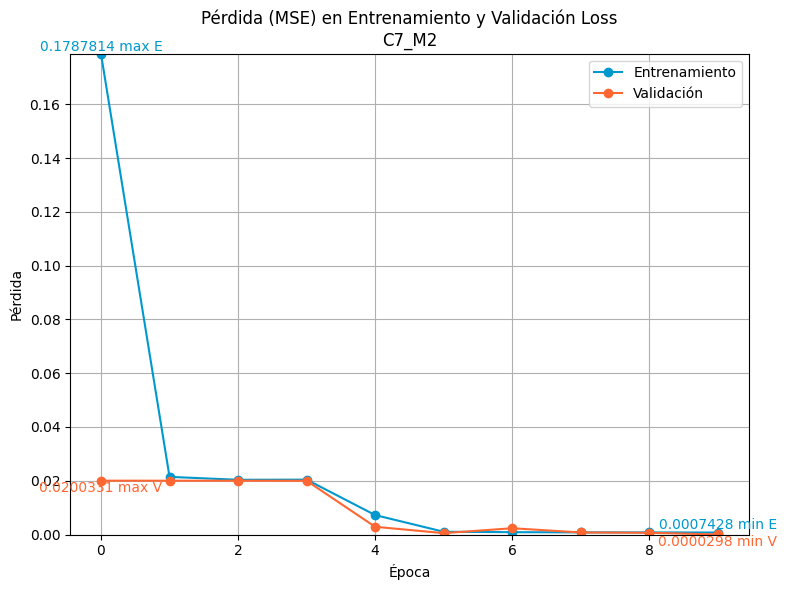


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 2.8820e-05
Pérdida (MSE) : 2.8820497391279787e-05
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 6.0984137277476504
Raíz del Error Cuadrático Medio (RMSE): 2.46949665473506
Error Absoluto Medio (MAE): 1.8843557416628949
Puntuación R^2: 0.998535925823023


<Figure size 640x480 with 0 Axes>

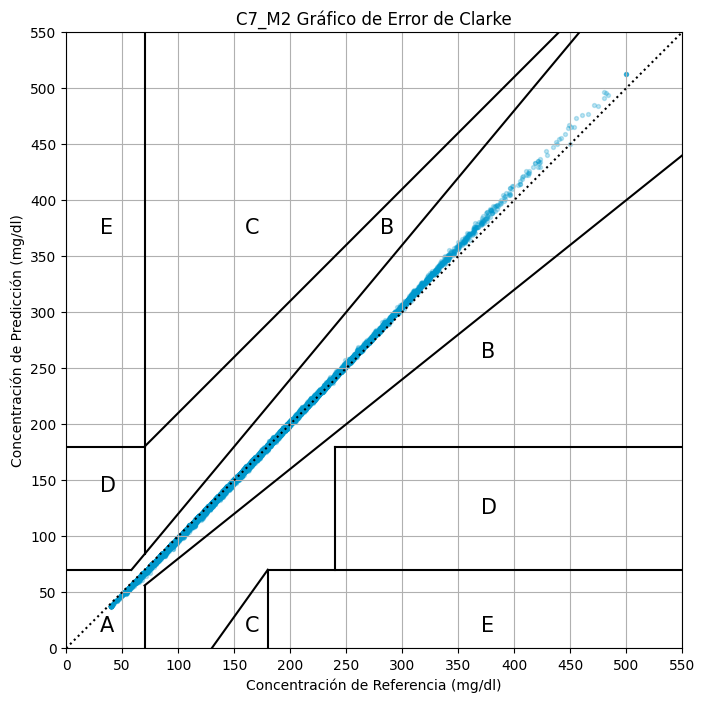

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C7_M3) ====

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_27 (CuDNNLSTM)   (None, 128)               67584     
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_65 (Dense)            (None, 256)               33024     
            

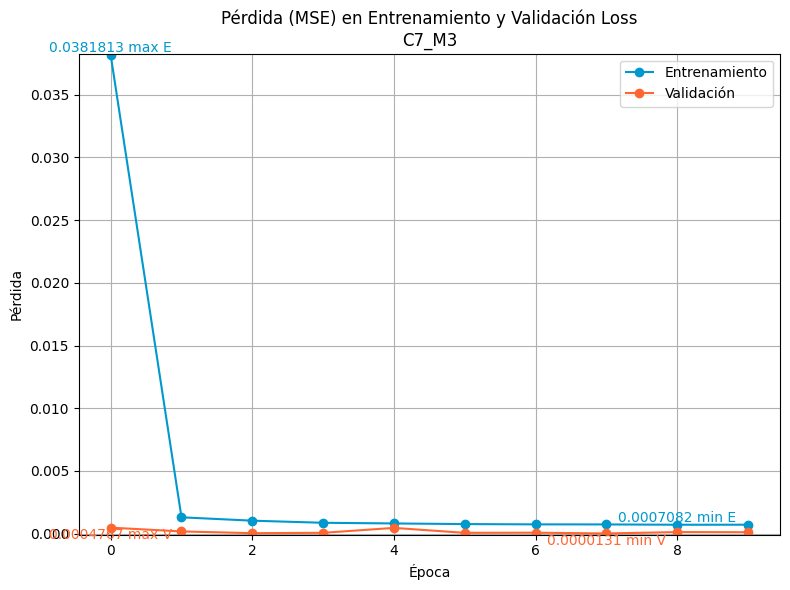


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 2ms/step - loss: 1.1009e-04
Pérdida (MSE) : 0.00011008913133991882
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 23.29485999854962
Raíz del Error Cuadrático Medio (RMSE): 4.826474903959371
Error Absoluto Medio (MAE): 4.386941380946627
Puntuación R^2: 0.9944074960304853


<Figure size 640x480 with 0 Axes>

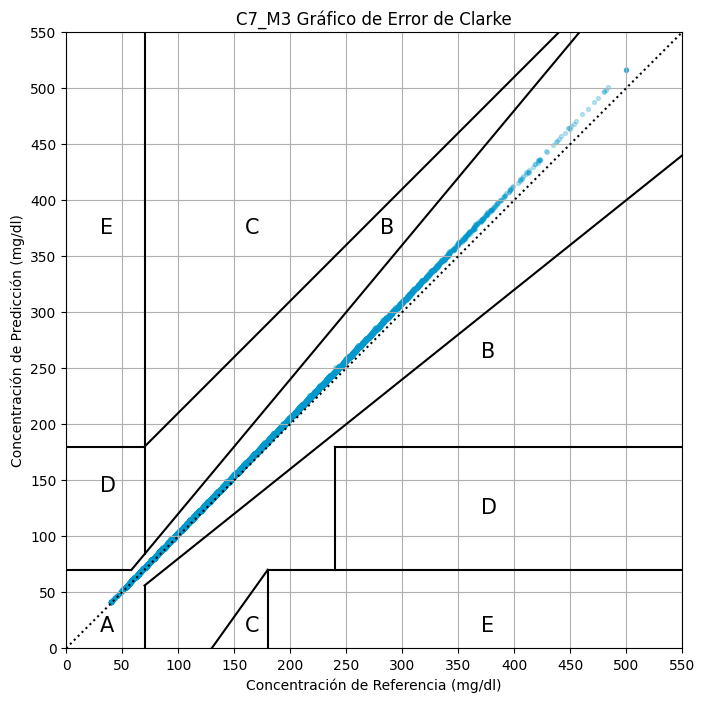

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


===== Caso8 =====
Variables usadas: ['Month', 'Day', 'Weekday', 'Daytime', 'Trend', 'Diagnostic', 'Difference']
Creando conjuntos de Entrenamiento, Validación y Prueba
Secuencias totales: 210696 (2528352 registros)
 - Secuencias de entrenamiento: 168556 (80%) - Etiquetas de entrenamiento: 168556
Primera secuencia: 
[0.63636364 0.16666667 0.5        0.66666667 0.5        0.5
 0.5        0.14565217 0.63636364 0.16666667 0.5        0.66666667
 1.         0.5        0.50742574 0.15217391 0.63636364 0.16666667
 0.5        0.66666

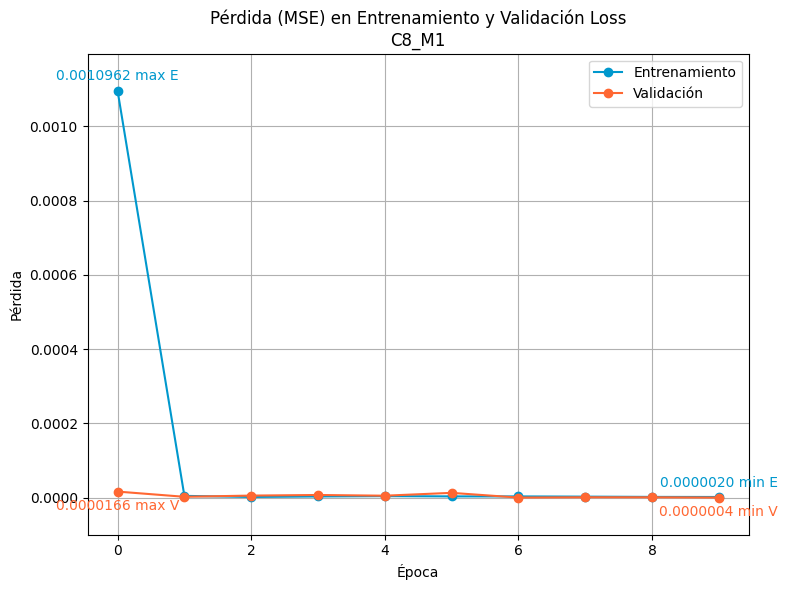


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 3.8647e-07
Pérdida (MSE) : 3.8647348787890223e-07
659/659 [==============================] - 1s 1ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 0.08177771762964589
Raíz del Error Cuadrático Medio (RMSE): 0.2859680360278853
Error Absoluto Medio (MAE): 0.24457633874401485
Puntuación R^2: 0.9999803672479469


<Figure size 640x480 with 0 Axes>

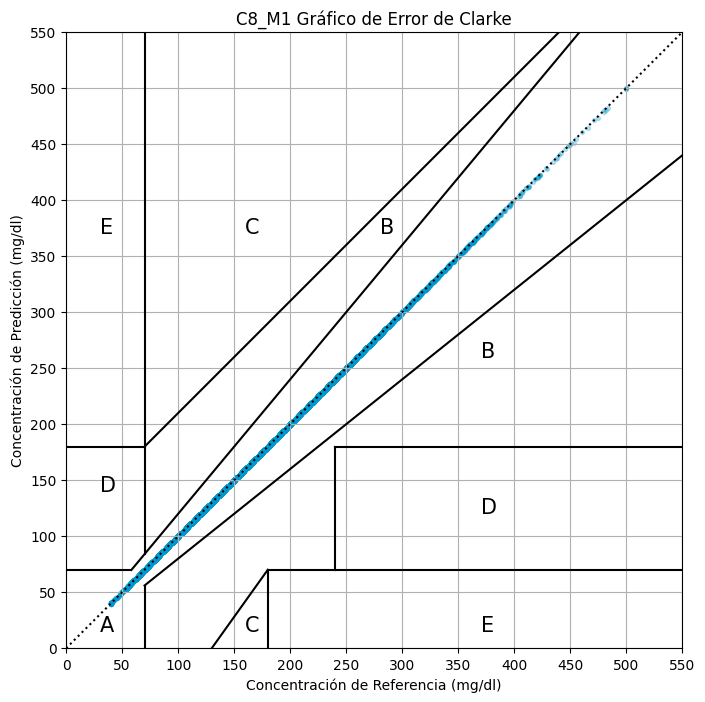

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Segundo modelo (C8_M2) ====

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_29 (CuDNNLSTM)   (None, 12, 256)           272384    
                                                                 
 dropout_56 (Dropout)        (None, 12, 256)           0         
                                                                 
 cu_dnnlstm_30 (CuDNNLSTM)   (None, 128)               197632    
           

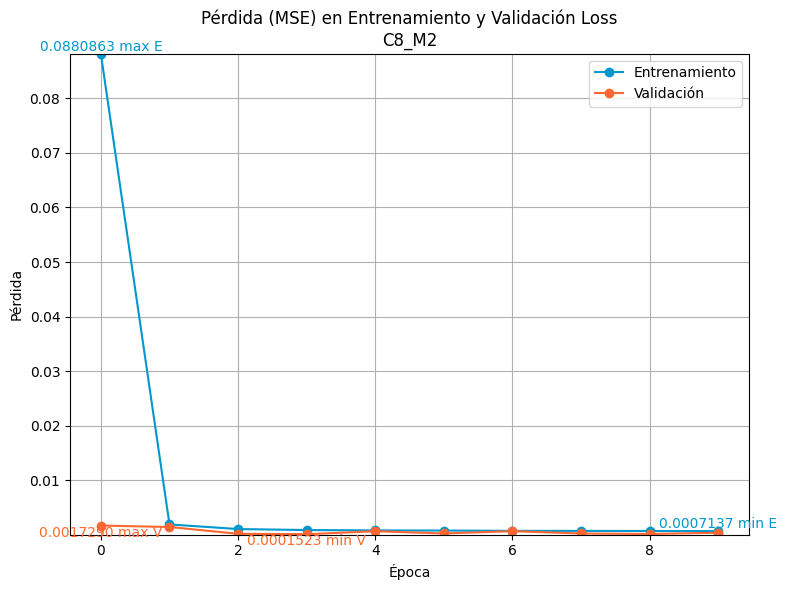


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 2s 3ms/step - loss: 4.0859e-04
Pérdida (MSE) : 0.00040858692955225706
659/659 [==============================] - 2s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 86.45700414075178
Raíz del Error Cuadrático Medio (RMSE): 9.298225859848307
Error Absoluto Medio (MAE): 8.387368095300182
Puntuación R^2: 0.9792438701550638


<Figure size 640x480 with 0 Axes>

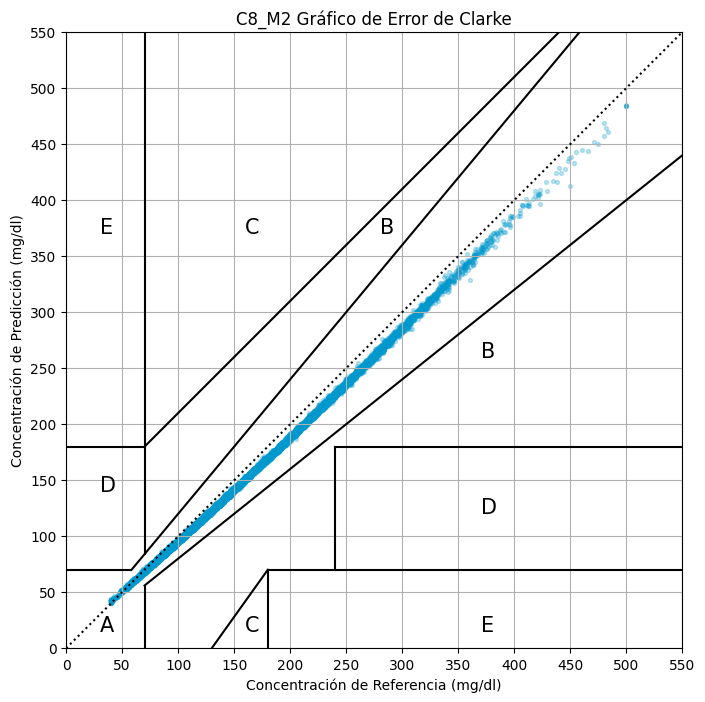

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070


==== Tercer modelo (C8_M3) ====

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_31 (CuDNNLSTM)   (None, 128)               70656     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 256)               33024     
            

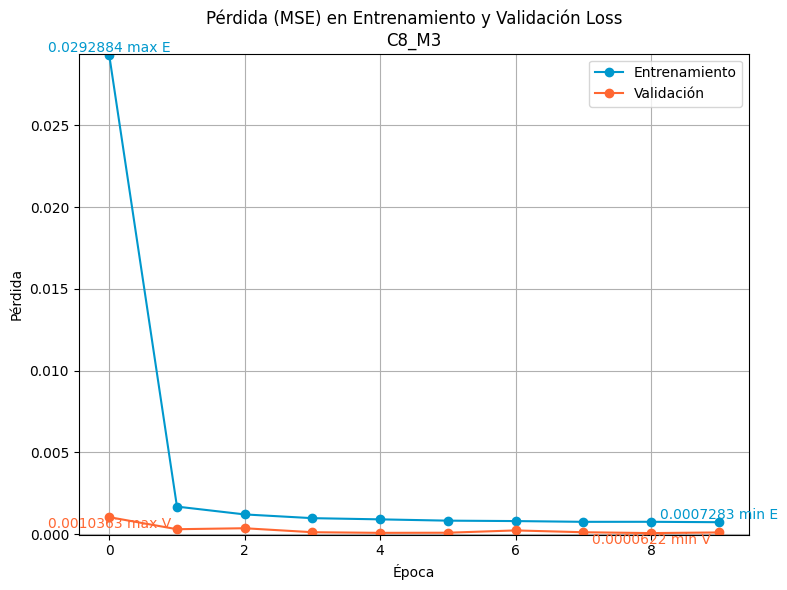


==== Resultados de evaluación del modelo ====

659/659 [==============================] - 1s 2ms/step - loss: 1.0131e-04
Pérdida (MSE) : 0.00010130504233529791
659/659 [==============================] - 1s 2ms/step

==== Resultados de test ====

Error Cuadrático Medio (MSE): 21.43614132872398
Raíz del Error Cuadrático Medio (RMSE): 4.629918069331679
Error Absoluto Medio (MAE): 3.9207423329183584
Puntuación R^2: 0.9948537271535681


<Figure size 640x480 with 0 Axes>

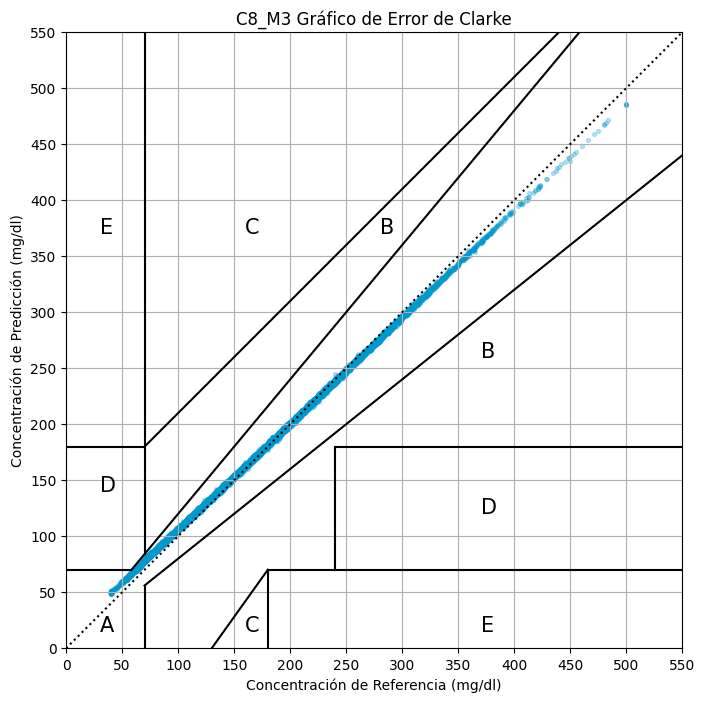

Región A: 21070 puntos (100.0%) dentro del 20% del sensor de referencia
Región B: 0 puntos (0.0%) fuera del 20% pero no conduciría a un tratamiento inapropiado
Región C: 0 puntos (0.0%) que indican un tratamiento innecesario
Región D: 0 puntos (0.0%) que indican un potencial fallo peligroso en la detección de hipoglucemia o hiperglucemia
Región E: 0 puntos (0.0%) que podrían confundir el tratamiento de hipoglucemia con hiperglucemia y viceversa
Total casos: 21070



In [18]:
# Combinaciones de variables para los casos de experimentos.
cases_summary = {
    'Caso1':[['Measurement']],
    'Caso2':[['Month','Day']],
    'Caso3':[['Weekday']],
    'Caso4':[['Hour','Minute']],
    'Caso5':[['Daytime']],
    'Caso6':[['Trend','Diagnostic']],
    'Caso7':[['Difference']],
    'Caso8':[['Month','Day','Weekday','Daytime','Trend','Diagnostic','Difference']]
}
# Verificar si ya existe el archivo CSV con datos de series temporales.
if not os.path.exists(TIME_SERIES_PATH):
    # Si el archivo no existe, cargar los datos originales desde 'Glucose_measurements_sample.csv'.
    df_glucose = pd.read_csv('Glucose_measurements_sample.csv')
    # Realizar diferentes manipulaciones de los datos para obtener la serie temporal deseada.
    measurementsPerPatient(df_glucose)
    monthlyMeasurement(df_glucose)
    monthlyMeasurementPerYear(df_glucose)    
    plotCorrelation(df_glucose, INITIAL_COLUMNS, "inicial")
    df_glucose = addAdditionalVariables(df_glucose)    
    weekdayMeasurement(df_glucose)
    daytimeMeasurement(df_glucose)
    plotCorrelation(df_glucose, FINAL_COLUMNS, "final")
    time_series = createTemporalSeries(df_glucose)
    # Guardar los datos de la serie temporal en un archivo CSV.
    time_series.to_csv(TIME_SERIES_PATH)
else:
    # Si el archivo ya existe, cargar los datos de la serie temporal desde el archivo CSV.
    time_series = pd.read_csv(TIME_SERIES_PATH)
# Ejecutar los casos de experimentos utilizando los datos de series temporales y combinaciones de variables.
cases_summary = runCases(time_series, cases_summary)

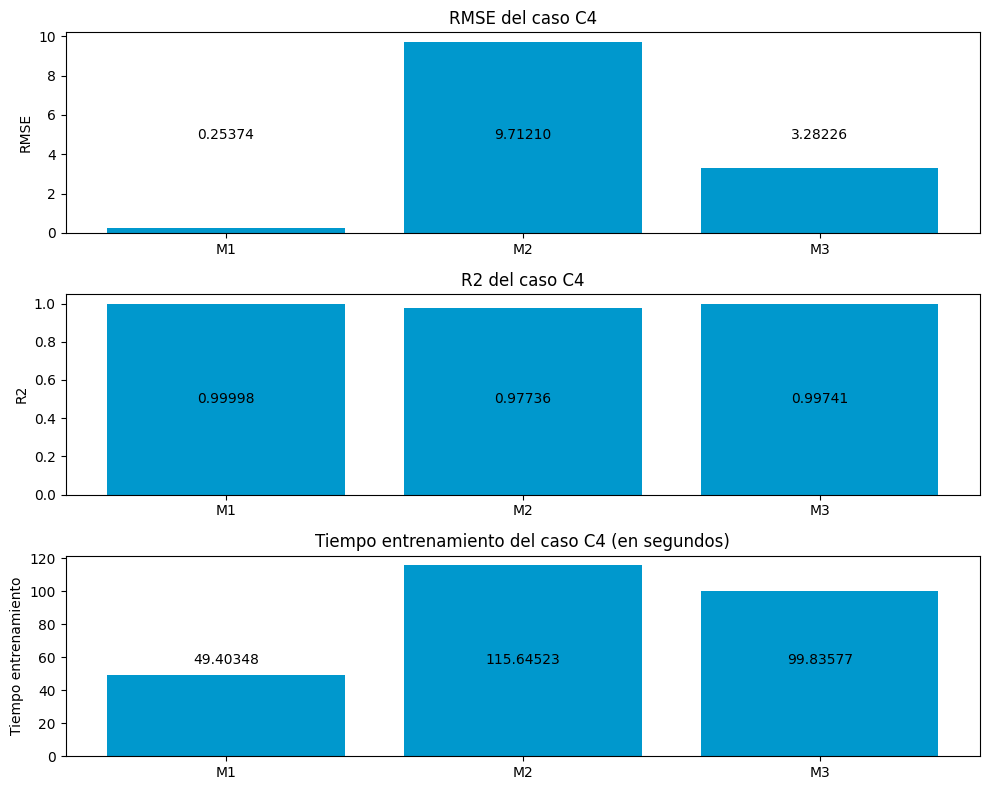

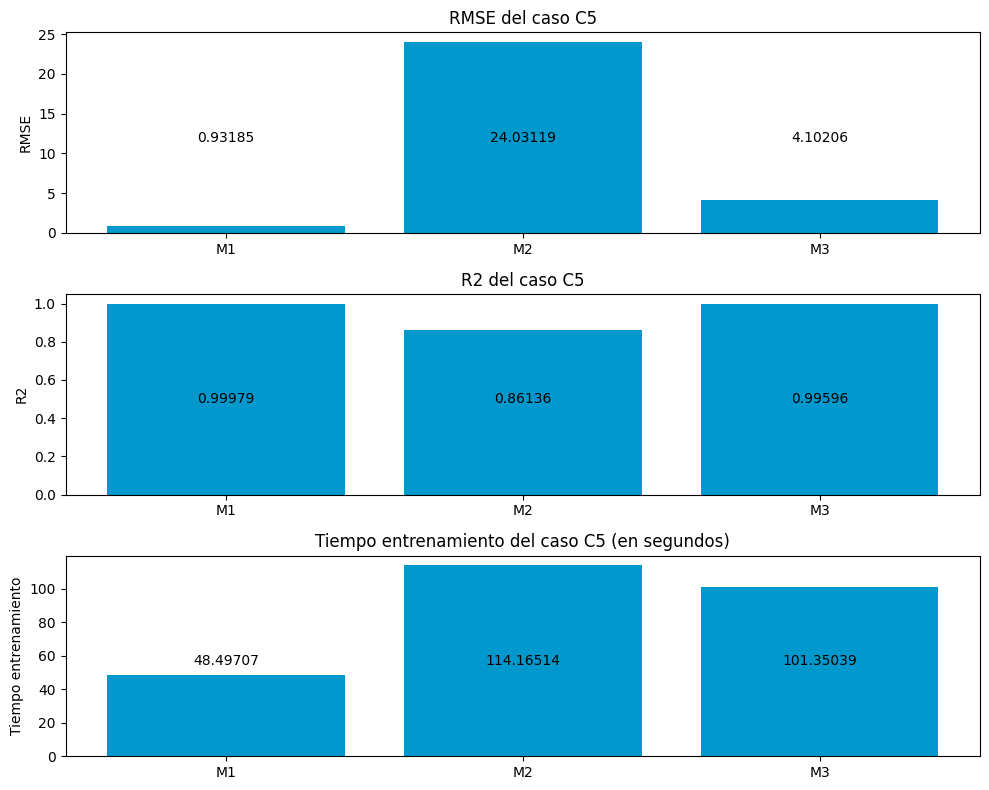

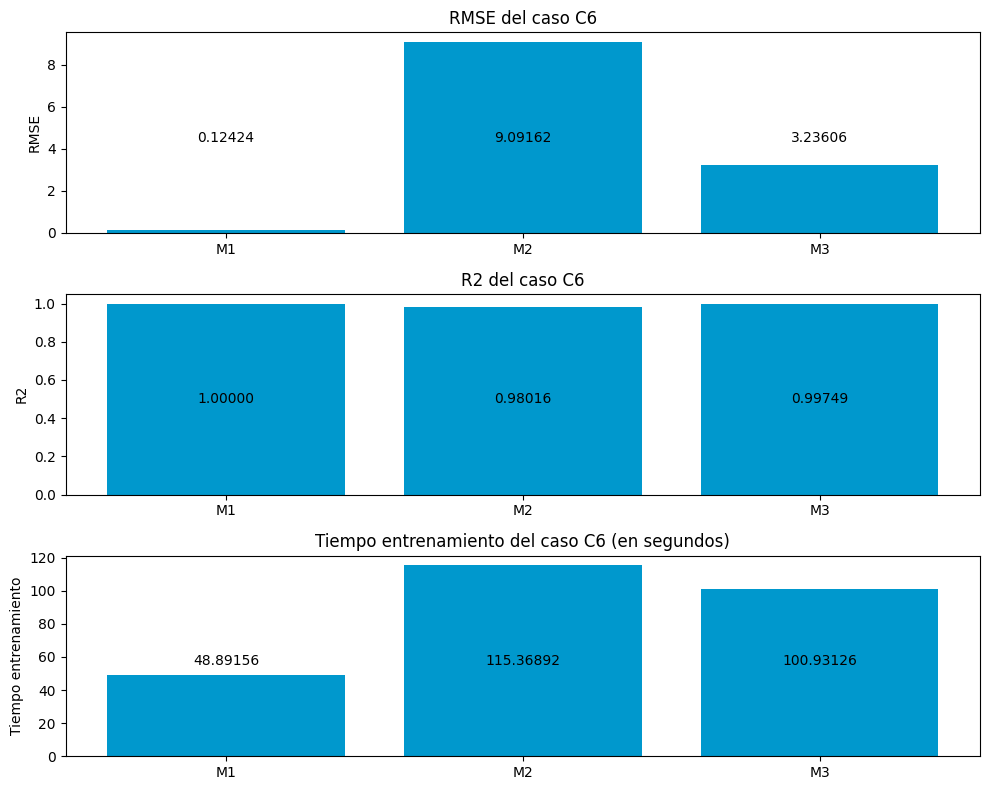

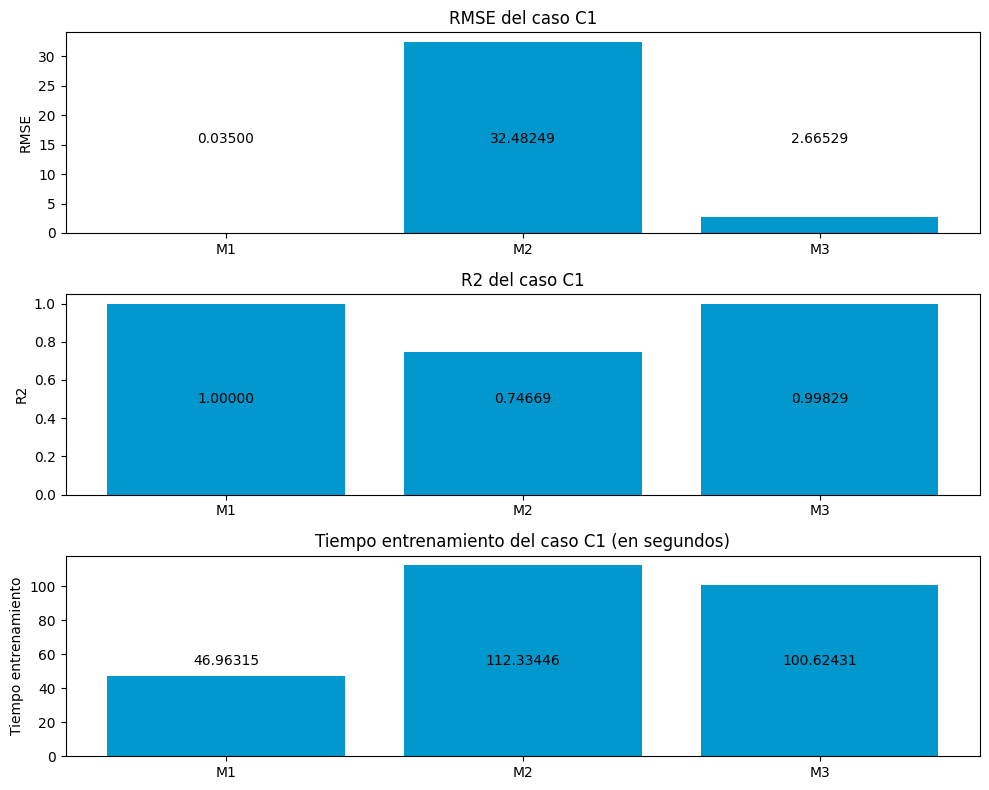

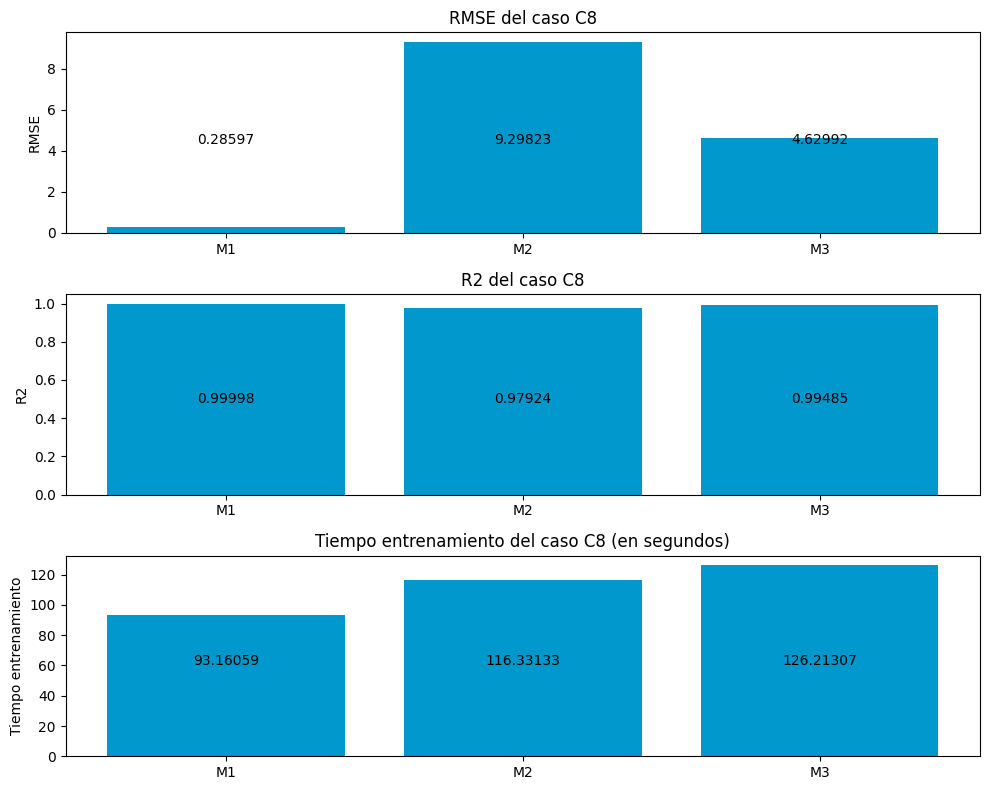

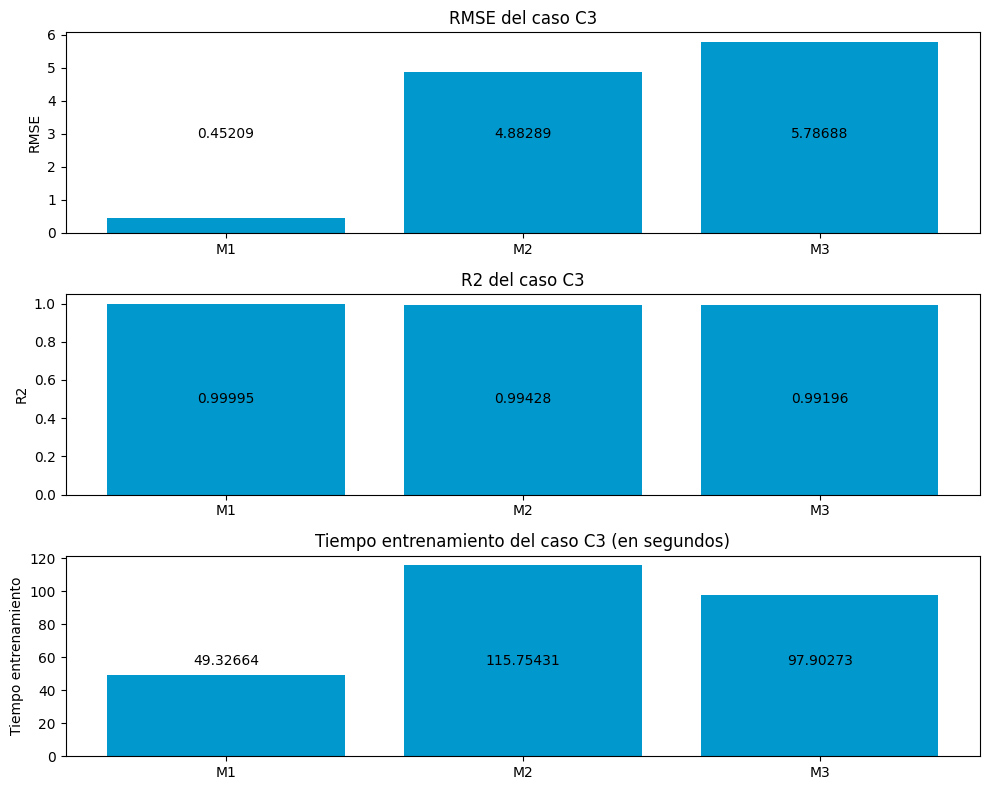

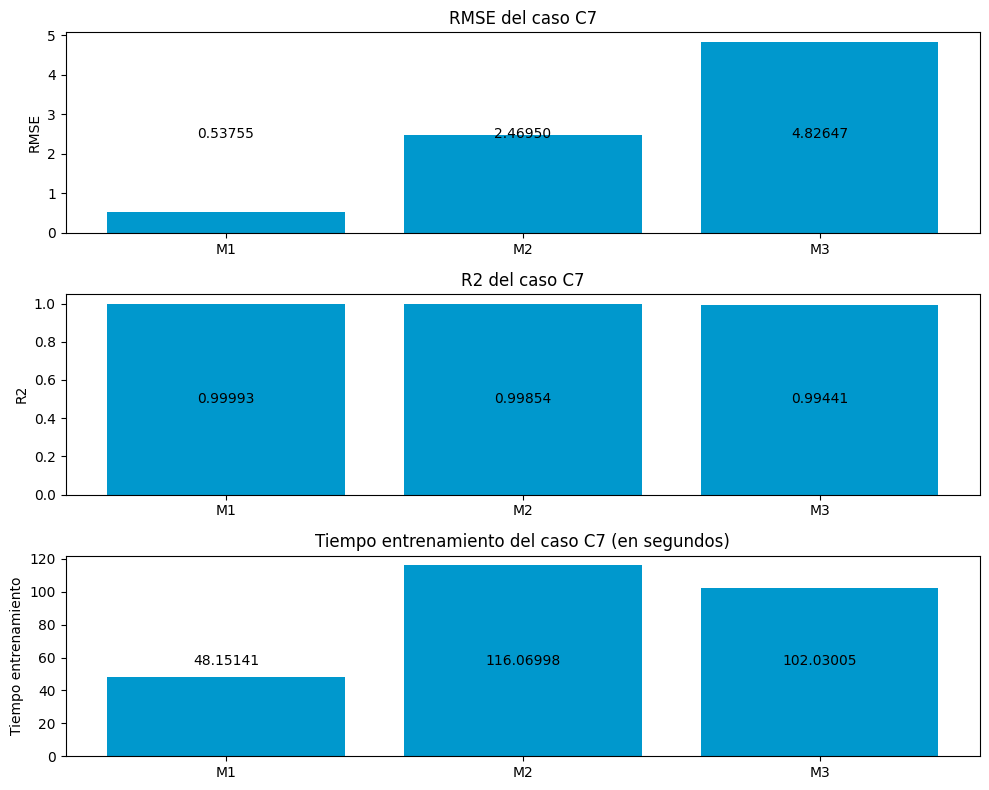

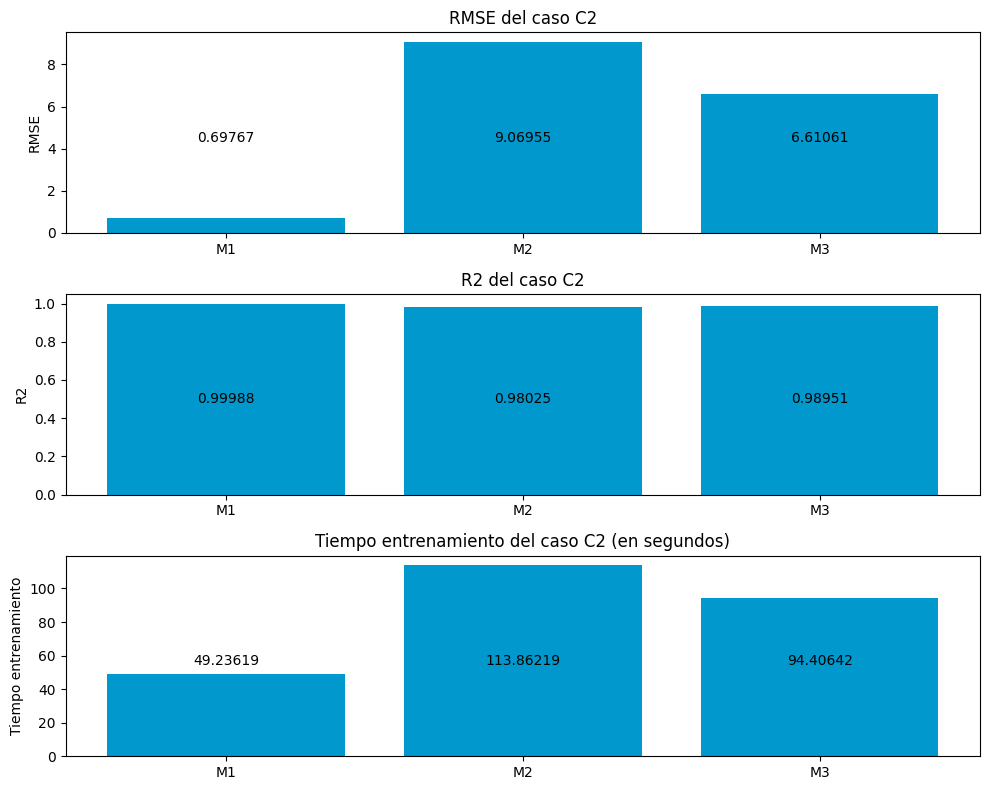

In [34]:
def create_metrics_graphs(data, metric_names):
    cases = set(data['Caso'])
    
    for case in cases:
        case_data = data[data['Caso'] == case]
        models = case_data['Modelo']
        
        plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura
        
        max_height = 0  # Inicializar la altura máxima en 0
        
        for i, metric_name in enumerate(metric_names, 1):
            metric_values = case_data[metric_name]
            
            plt.subplot(len(metric_names), 1, i)
            bars = plt.bar(models, metric_values, color=UNIR_COLOR)
            plt.ylabel(metric_name)
            aditional = ''
            if metric_name == 'Tiempo entrenamiento':
                aditional = " (en segundos)"
            plt.title('{} del caso {}{}'.format(metric_name, case, aditional))
            # plt.grid(True)
            
            max_height = 0
            for bar, value in zip(bars, metric_values):
                max_height=max(max_height,round(value,0))
            
            for bar, value in zip(bars, metric_values):
                plt.text(bar.get_x() + bar.get_width() / 2, max_height/2 , '{:.5f}'.format(value), 
                         ha='center', va='center', color='black')  # Posición en la mitad de la barra, texto en negro
               
        # Guardar el gráfico en una carpeta de salida (METRICS_FOLDER) con un nombre específico.
        plt.tight_layout()  # Ajustar los subplots para que no haya superposición de títulos o etiquetas
        plt.savefig(os.path.join(METRICS_FOLDER, '{}.png'.format(case)))
        plt.show()
        plt.close()  # Cerrar la figura actual antes de pasar al siguiente caso.

data = pd.read_csv(SUMMARY_PATH)
create_metrics_graphs(data, ['RMSE','R2','Tiempo entrenamiento'])

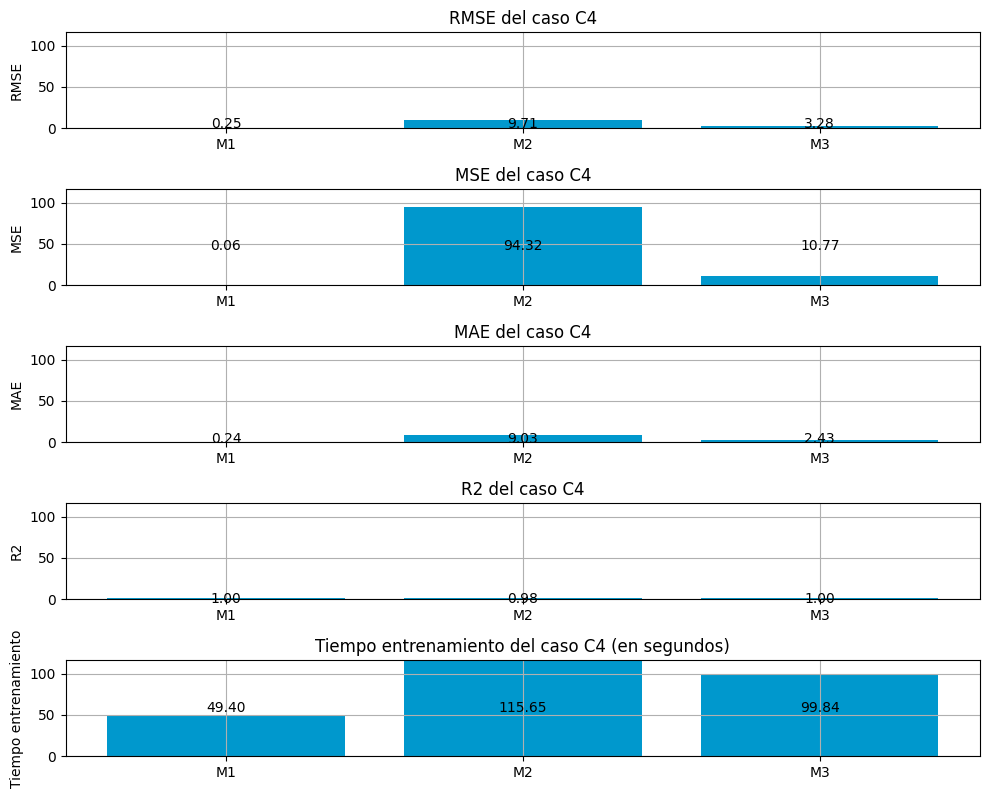

C:\Users\XCoret\AppData\Local\Temp\ipykernel_34032\3716490078.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajustar los subplots para que no haya superposición de títulos o etiquetas


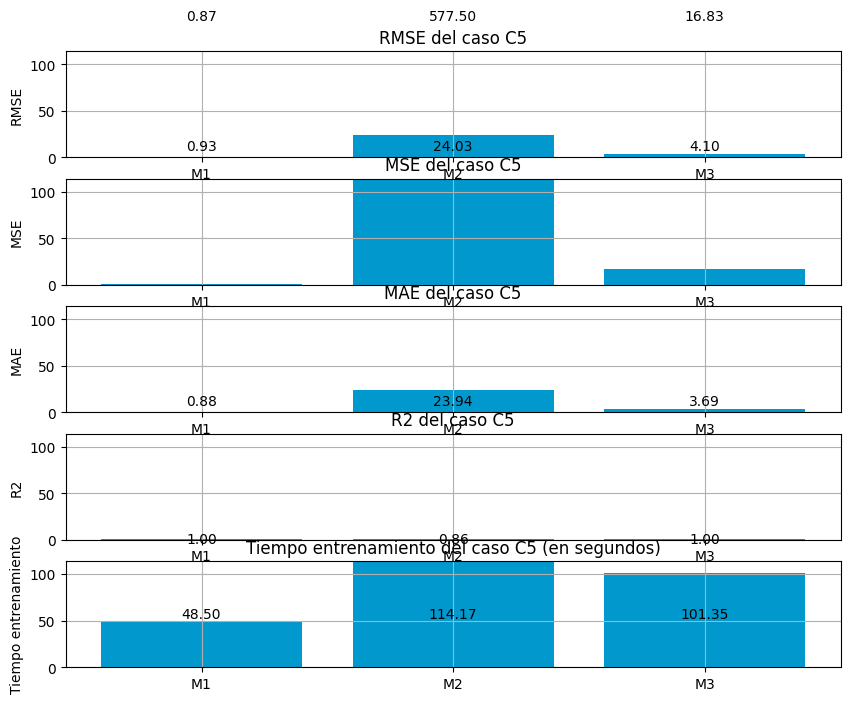

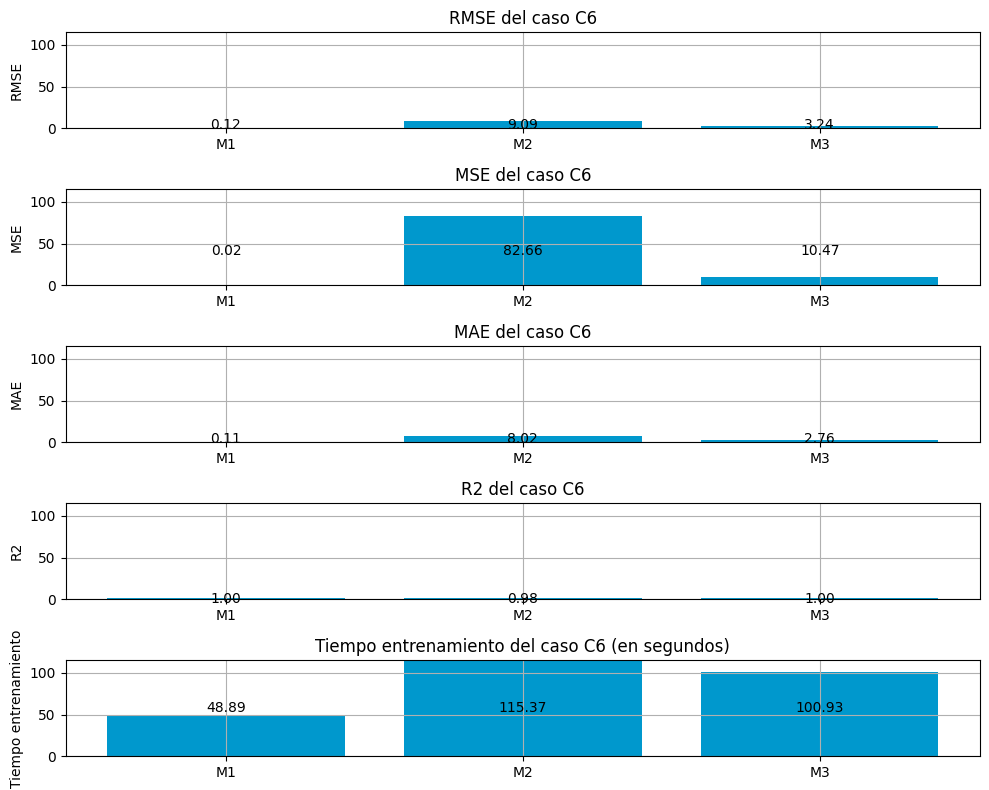

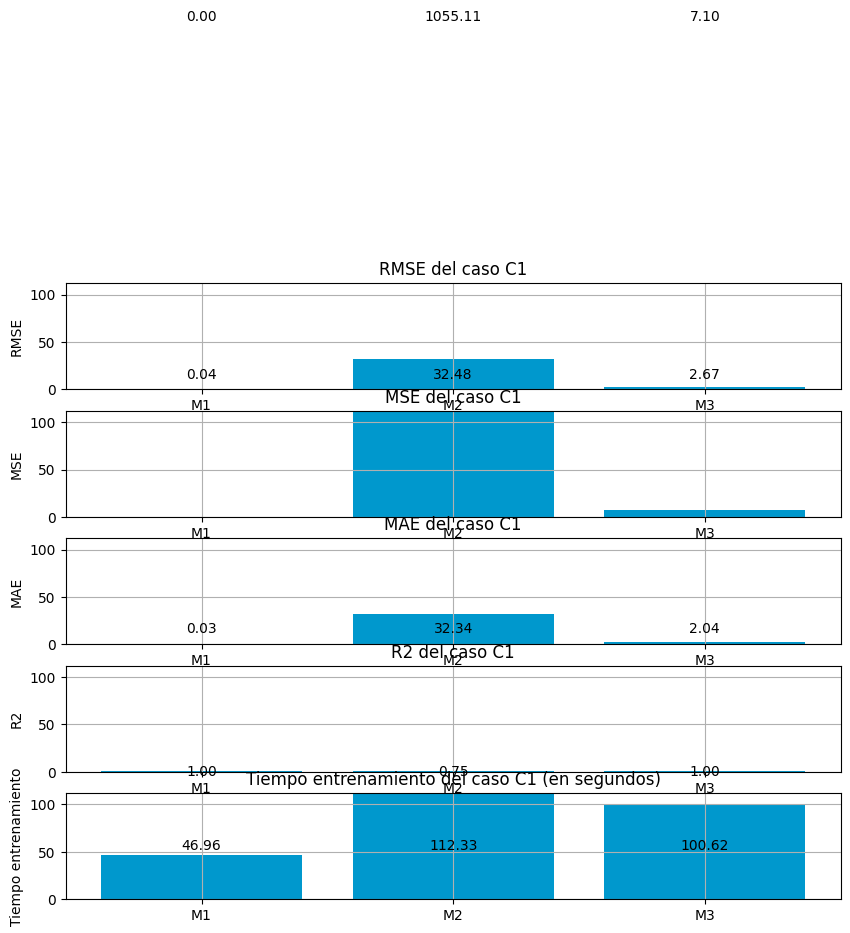

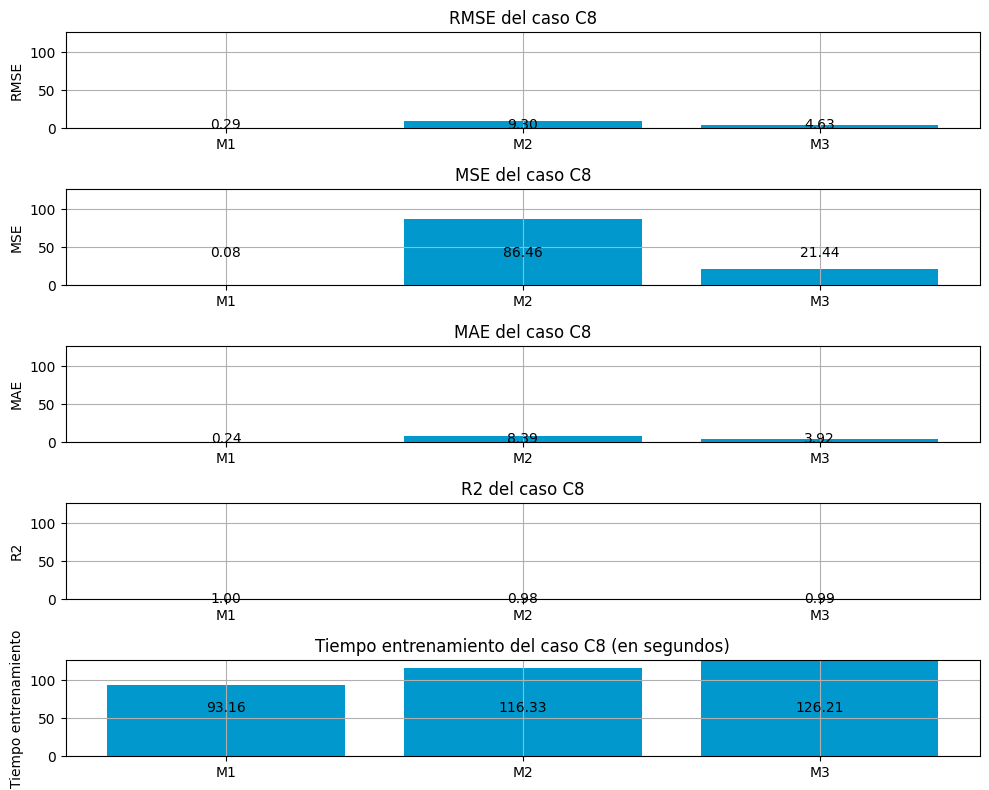

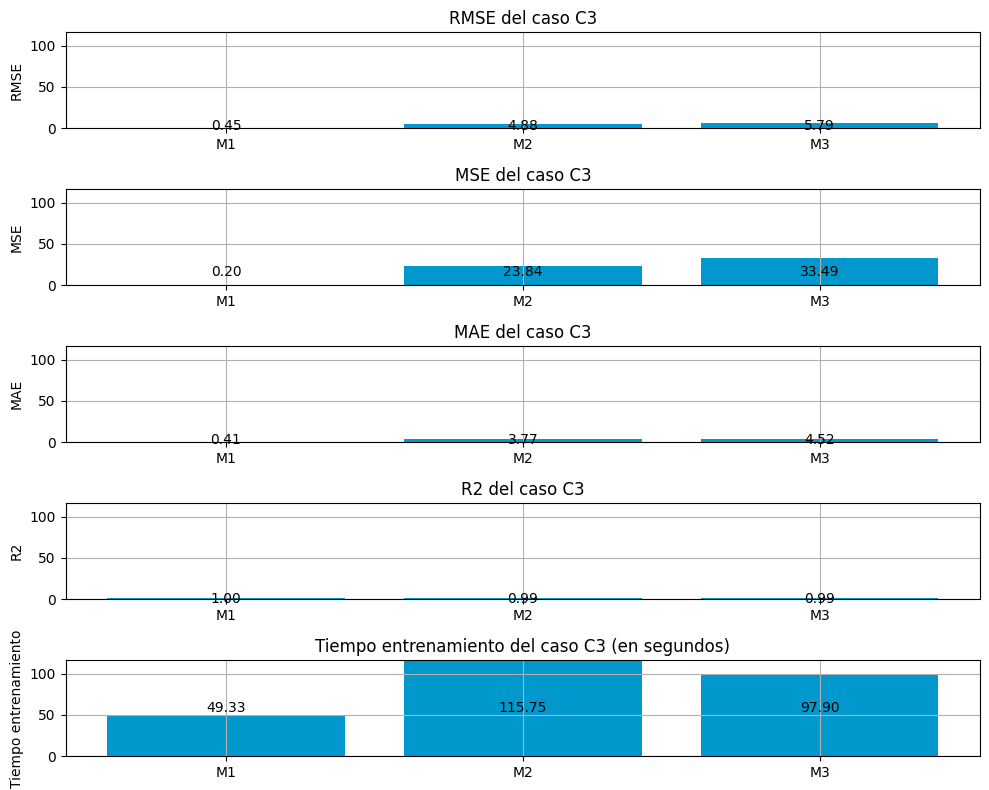

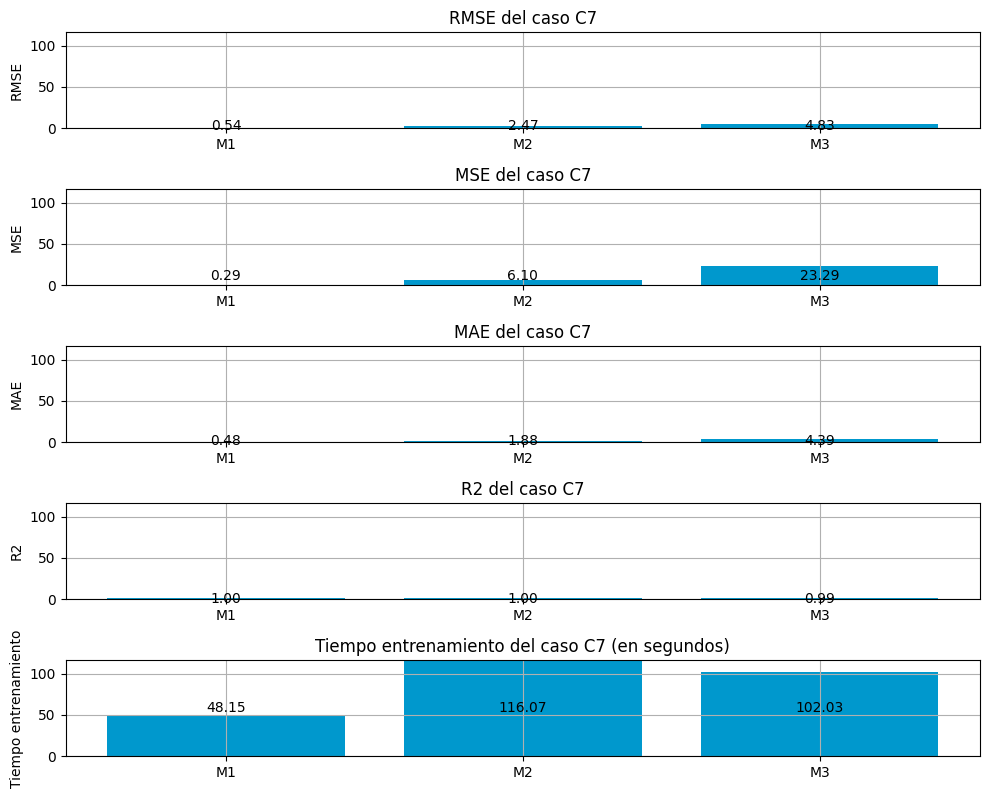

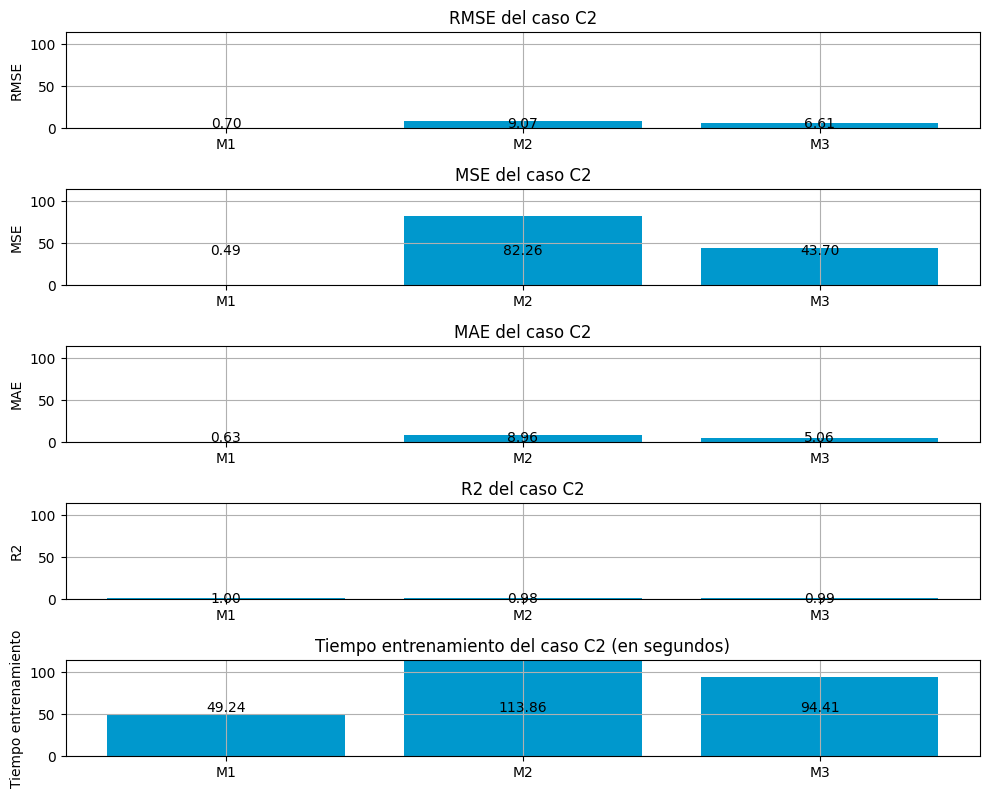

In [22]:
create_metrics_graphs(data, ['RMSE','MSE','MAE','R2','Tiempo entrenamiento'])